# H12 genome-wide selection scans

This notebook runs genome-wide selection scans.

In [1]:
%run setup.ipynb

In [2]:
pops = list(pop_defs)
pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [3]:
for pop, config in pop_defs.items():
    print(pop, 
          config['h12_window_size'],
          len(df_haps_a.query(config['query'])))

ao_col 6000 156
bf_col 1000 150
bf_gam 1000 184
ci_col 2000 142
cm_sav_gam 1000 192
fr_gam 16000 48
ga_gam 10000 138
gh_col 1400 110
gh_gam 1600 24
gm 2600 130
gn_gam 1000 80
gq_gam 7000 18
gw 1000 182
ke 60000 96
ug_gam 1000 224


In [4]:
h12_root = zarr.open(str(here() / 'data/gwss/h12/h12.zarr'))

In [5]:
def compute_h12(pop, chromosome, window_size=None, window_step=200):
    if not window_size:
        window_size = pop_defs[pop]['h12_window_size']
    if not window_step:
        window_step = window_size // 2
    
    # setup data
    if chromosome == 'X':
        loc_haps = df_haps_x.query(pop_defs[pop]['query']).index.values
        pos = callset_haps[chromosome]['variants/POS'][:]
        ht = allel.GenotypeDaskArray(callset_haps[chromosome]['calldata/GT']).to_haplotypes()
        ht_pop = da.take(ht, loc_haps, axis=1).compute()
        
    else:
        # concatenate data from both arms
        # remember, right arm goes on the left
        loc_haps = df_haps_a.query(pop_defs[pop]['query']).index.values
        arm_r = f'{chromosome}R'
        arm_l = f'{chromosome}L'
        pos_r = callset_haps[arm_r]['variants/POS'][:]
        pos_l = callset_haps[arm_l]['variants/POS'][:]
        pos = np.concatenate([pos_r, pos_l + len(genome[arm_r])])
        ht_r = allel.GenotypeDaskArray(callset_haps[arm_r]['calldata/GT']).to_haplotypes()
        ht_l = allel.GenotypeDaskArray(callset_haps[arm_l]['calldata/GT']).to_haplotypes()
        ht = da.concatenate([ht_r, ht_l], axis=0)
        ht_pop = da.take(ht, loc_haps, axis=1).compute()
        
    # perform the scan
    gpos = np.take(gmap[chromosome], pos-1)
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_step)
    gwindows = allel.moving_statistic(gpos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_step)
    h1, h12, h123, h2_h1 = allel.moving_garud_h(ht_pop, size=window_size, step=window_step)
    
    return windows, gwindows, h1, h12, h123, h2_h1


In [6]:
def run_h12(pop, chromosome, window_size=None, window_step=200, markersize=1):
    if not window_size:
        window_size = pop_defs[pop]['h12_window_size']
    if not window_step:
        window_step = window_size // 2
    
    # setup zarr group to store data
    grp_path = f'/{pop}/{window_size}/{window_step}/{chromosome}'
    grp = h12_root.require_group(grp_path)
    complete = grp.attrs.get('complete', False)
    
    if complete:
        # previously run, load from zarr
        windows = grp['windows'][:]
        gwindows = grp['gwindows'][:]
        h1 = grp['h1'][:]
        h12 = grp['h12'][:]
        h123 = grp['h123'][:]
        h2_h1 = grp['h2_h1'][:]
        
    else:
        # run scan and save to zarr
        windows, gwindows, h1, h12, h123, h2_h1 = compute_h12(
            pop, 
            chromosome=chromosome,
            window_size=window_size,
            window_step=window_step
        )
        grp.create_dataset('windows', data=windows, overwrite=True)
        grp.create_dataset('gwindows', data=gwindows, overwrite=True)
        grp.create_dataset('h1', data=h1, overwrite=True)
        grp.create_dataset('h12', data=h12, overwrite=True)
        grp.create_dataset('h123', data=h123, overwrite=True)
        grp.create_dataset('h2_h1', data=h2_h1, overwrite=True)
        grp.attrs['complete'] = True

    # scale figures to chromosome size
    figwidth = windows.max()/1e7
    palette = sns.color_palette("Reds", 4)[1:]
    
    # plot results for inspection - physical space
    x = windows.mean(axis=1)
    fig, ax = plt.subplots(facecolor='w', figsize=(figwidth, 3))
    ax.plot(x, h123, linestyle=' ', marker='o', color=palette[0], markersize=markersize, label='H123')
    ax.plot(x, h12, linestyle=' ', marker='o', color=palette[1], markersize=markersize, label='H12')
    ax.plot(x, h1, linestyle=' ', marker='o', color=palette[2], markersize=markersize, label='H1')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks/1e6)
    ax.set_xlabel(f'Chromosome {chromosome} position (Mbp)')
    ax.set_ylabel('H')
    ax.set_xlim(0, windows.max())
    ax.set_ylim(0, 1)
    ax.set_title(f"{pop_defs[pop]['label']}")
    lgd = ax.legend(loc='upper left')
    for handle in lgd.legendHandles:
        handle._legmarker.set_markersize(6)

    # plot results for inspection - genetic space
    x = gwindows.mean(axis=1)
    fig, ax = plt.subplots(facecolor='w', figsize=(figwidth, 3))
    ax.plot(x, h123, linestyle=' ', marker='o', color=palette[0], markersize=markersize, label='H123')
    ax.plot(x, h12, linestyle=' ', marker='o', color=palette[1], markersize=markersize, label='H12')
    ax.plot(x, h1, linestyle=' ', marker='o', color=palette[2], markersize=markersize, label='H1')
    ax.set_xlabel(f'Chromosome {chromosome} position (cM)')
    ax.set_ylabel('H')
    ax.set_xlim(0, gwindows.max())
    ax.set_ylim(0, 1)
    ax.set_title(f"{pop_defs[pop]['label']}")
    lgd = ax.legend(loc='upper left')
    for handle in lgd.legendHandles:
        handle._legmarker.set_markersize(6)

    plt.show()
    plt.close()


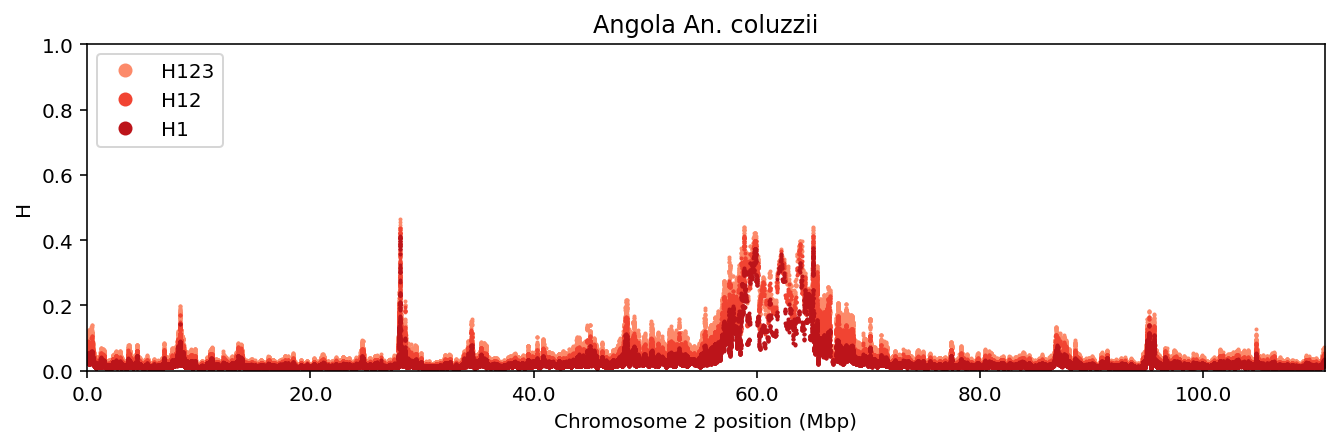

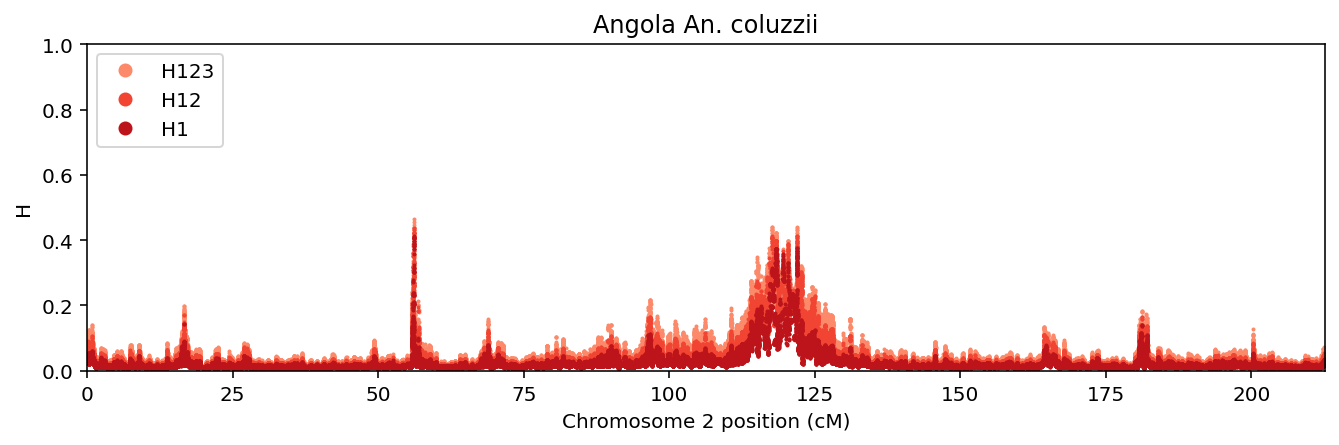

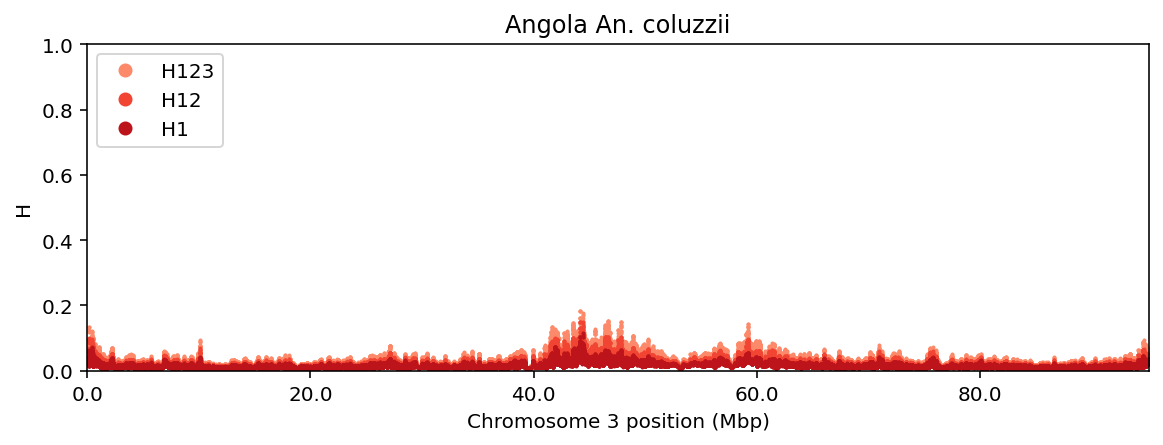

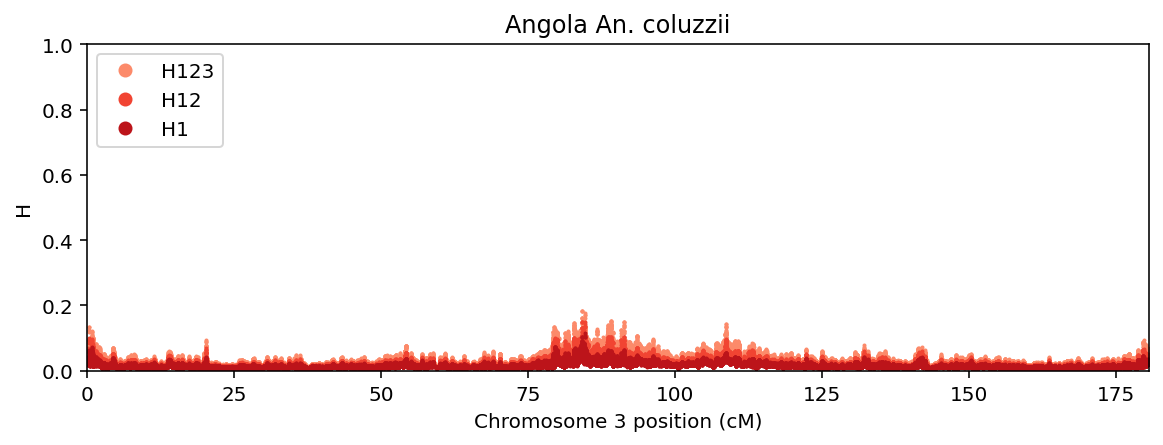

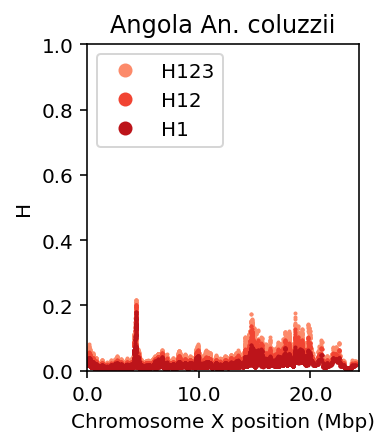

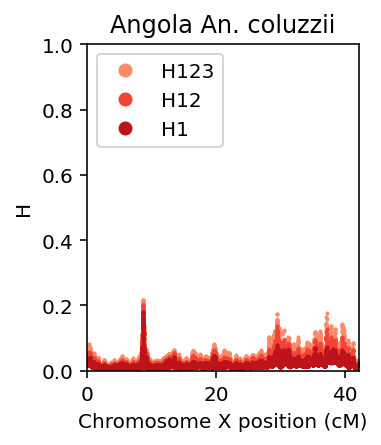

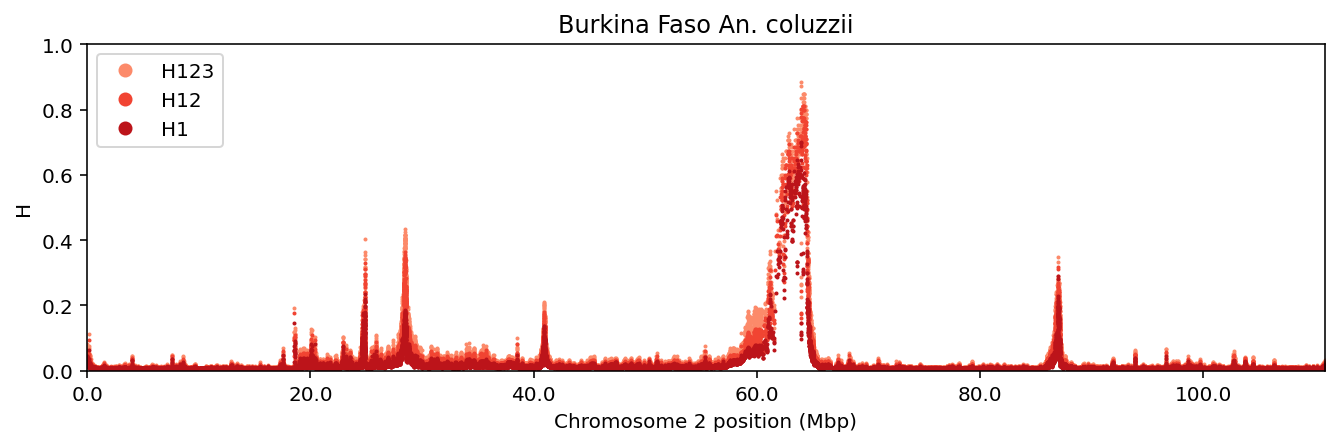

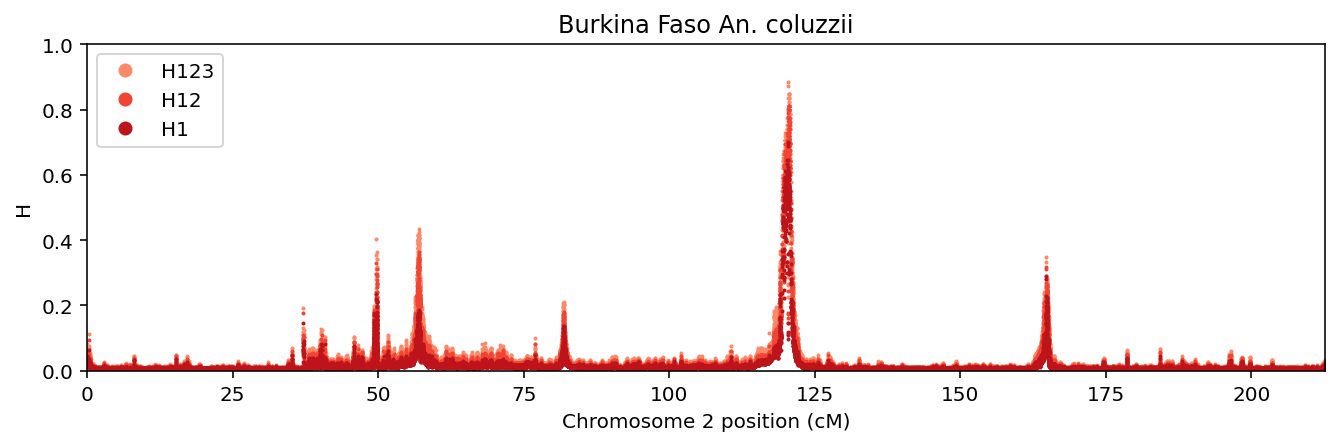

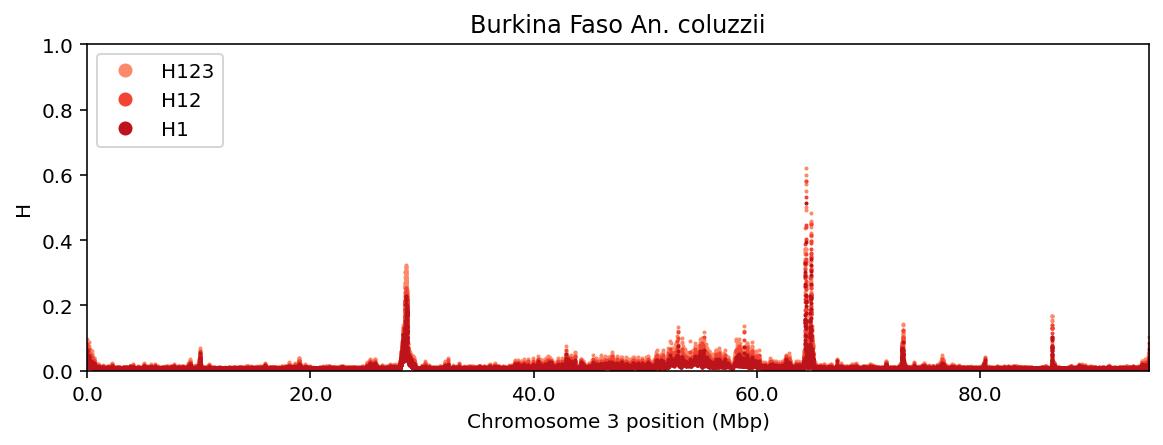

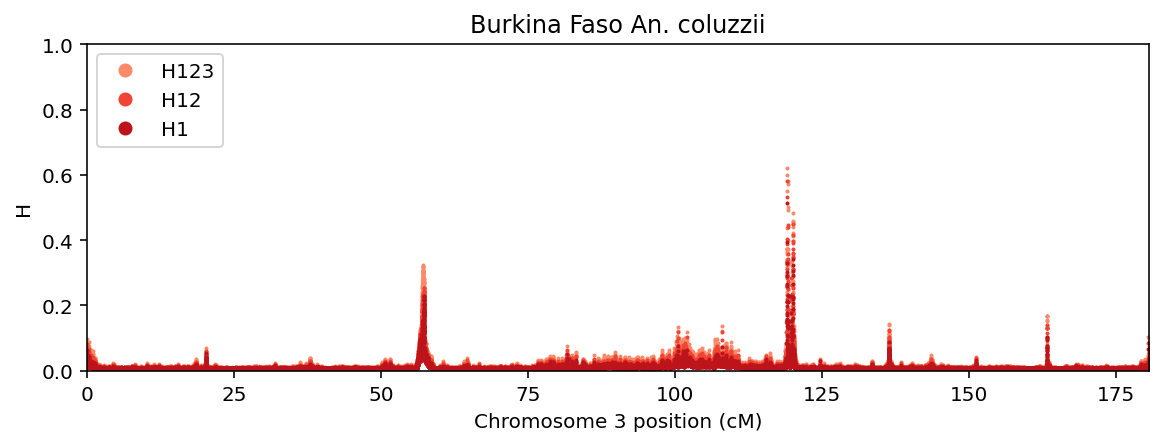

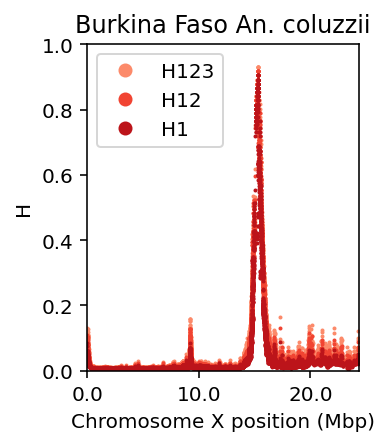

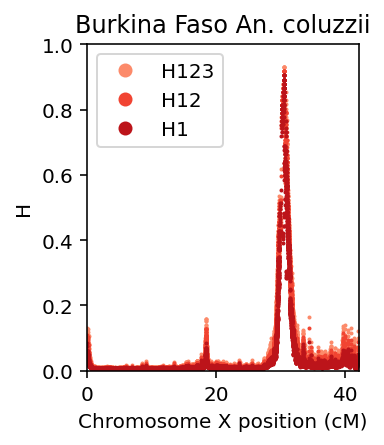

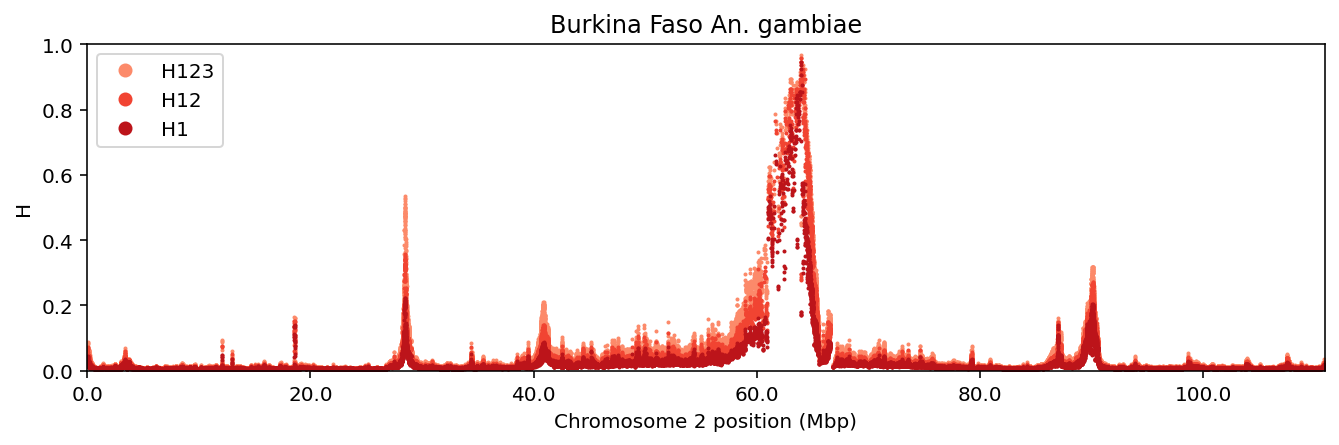

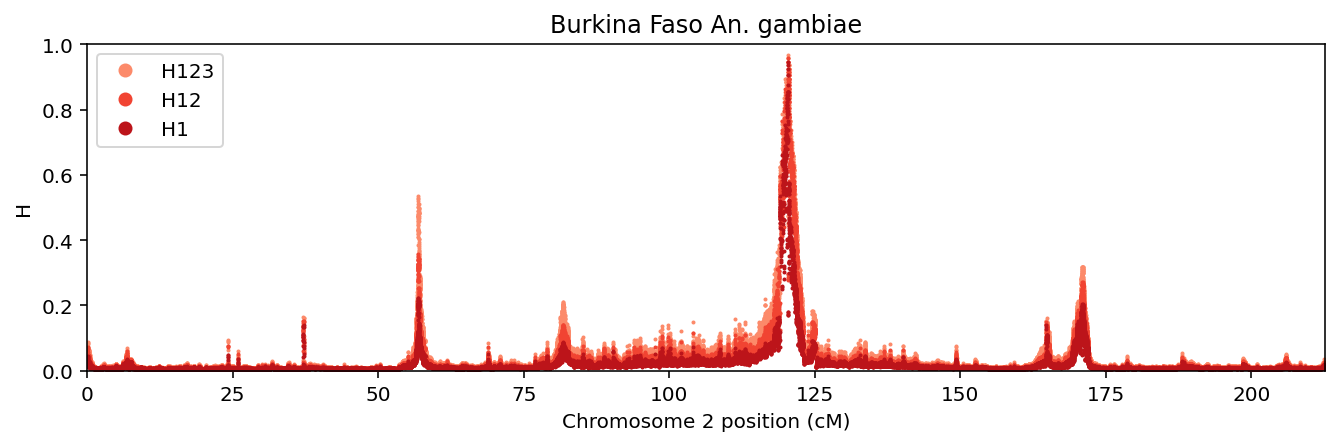

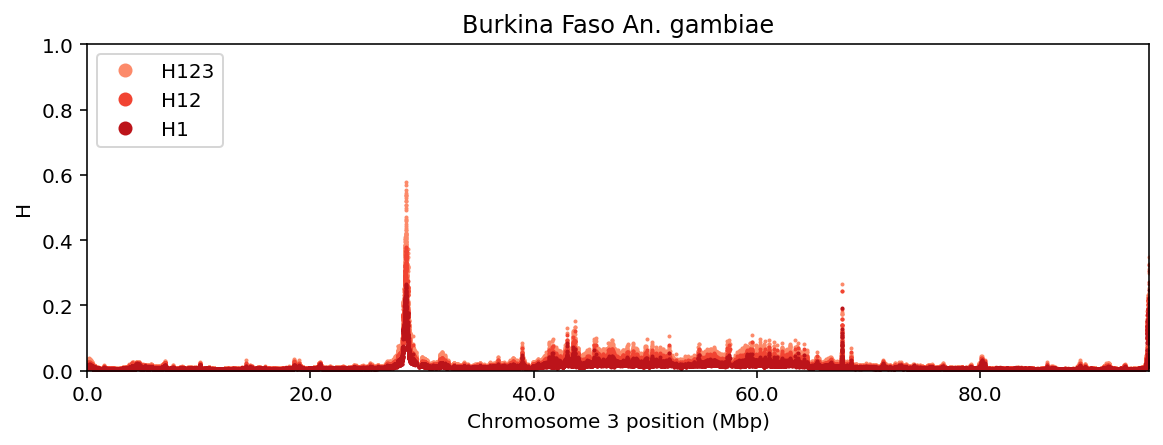

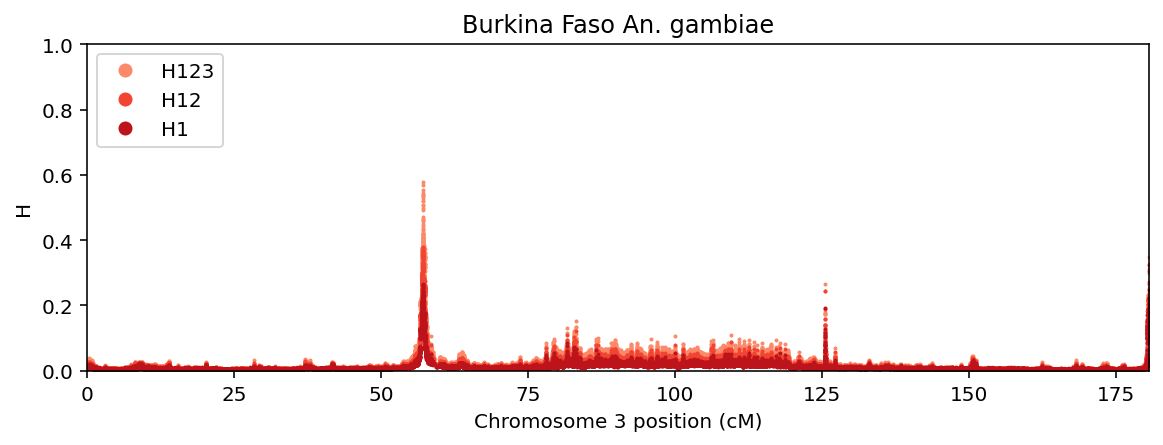

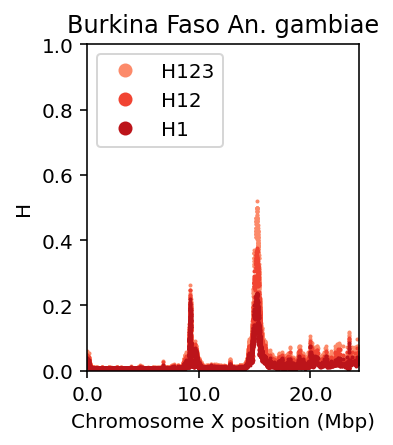

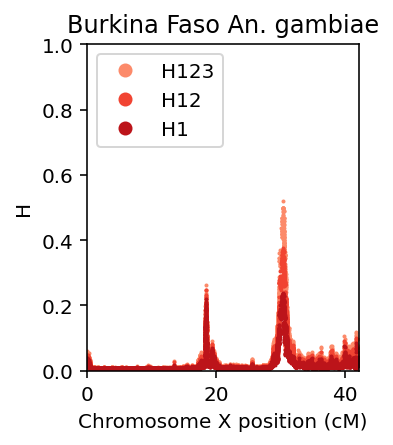

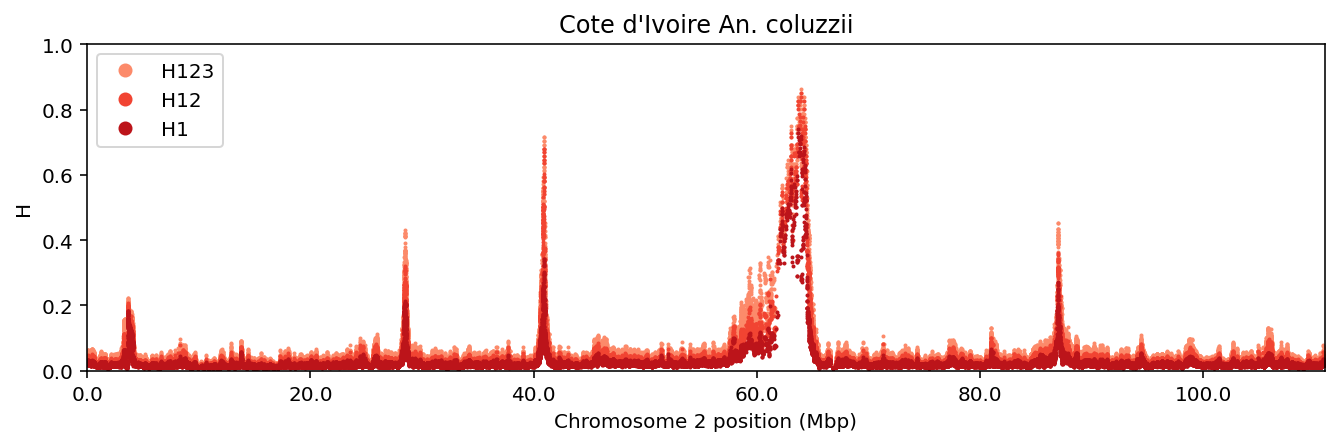

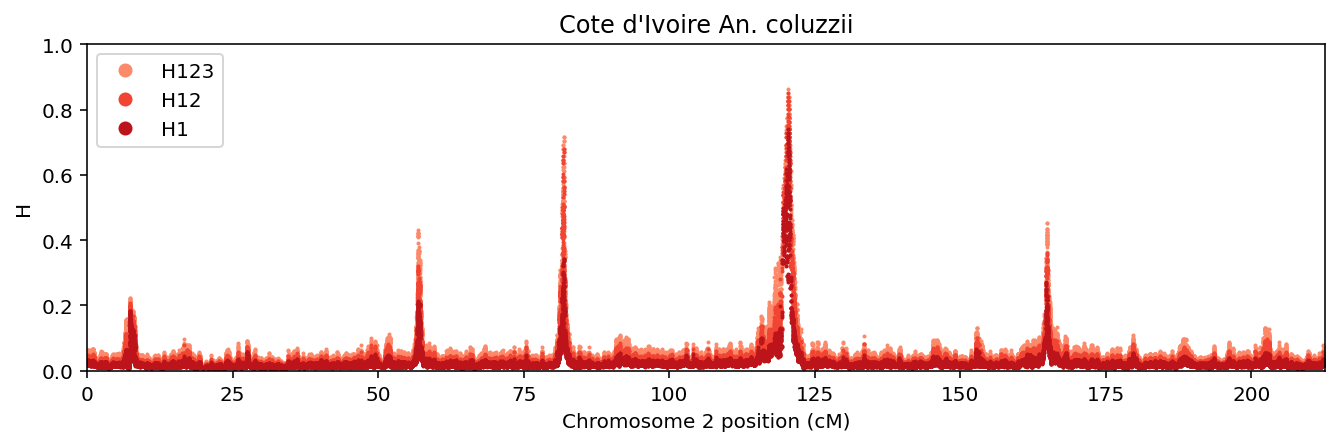

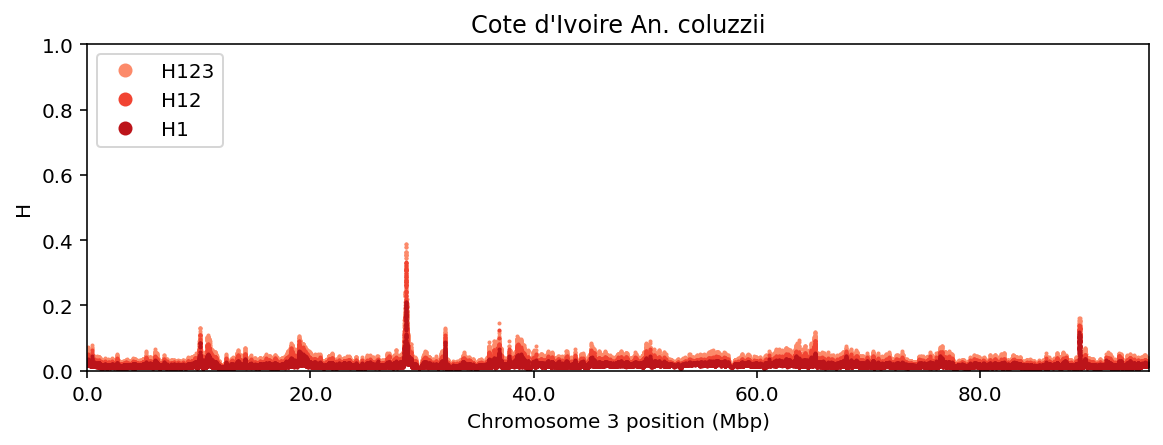

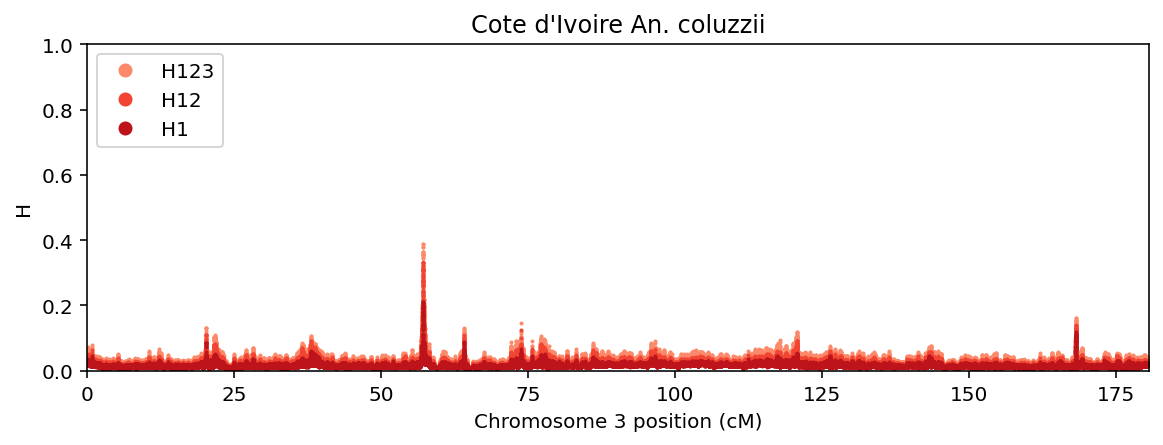

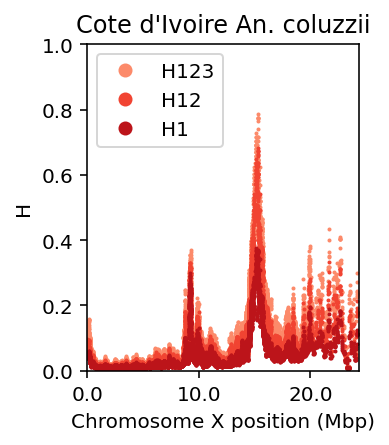

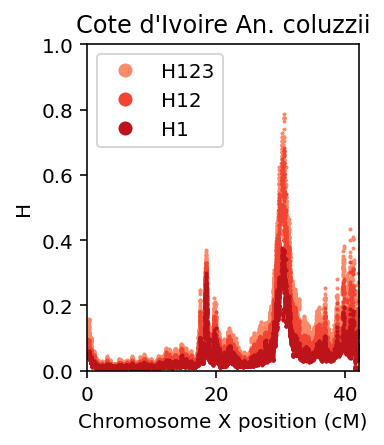

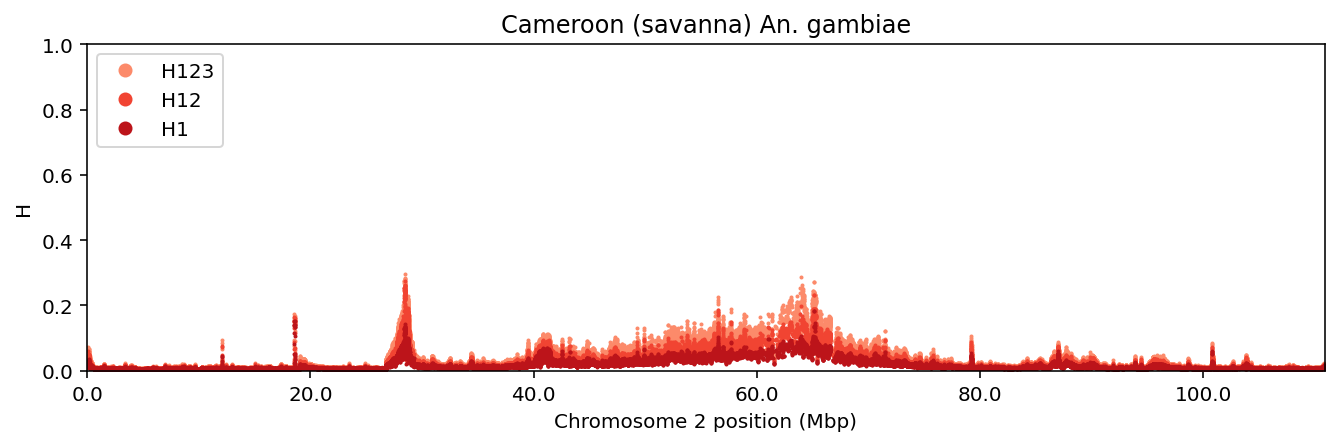

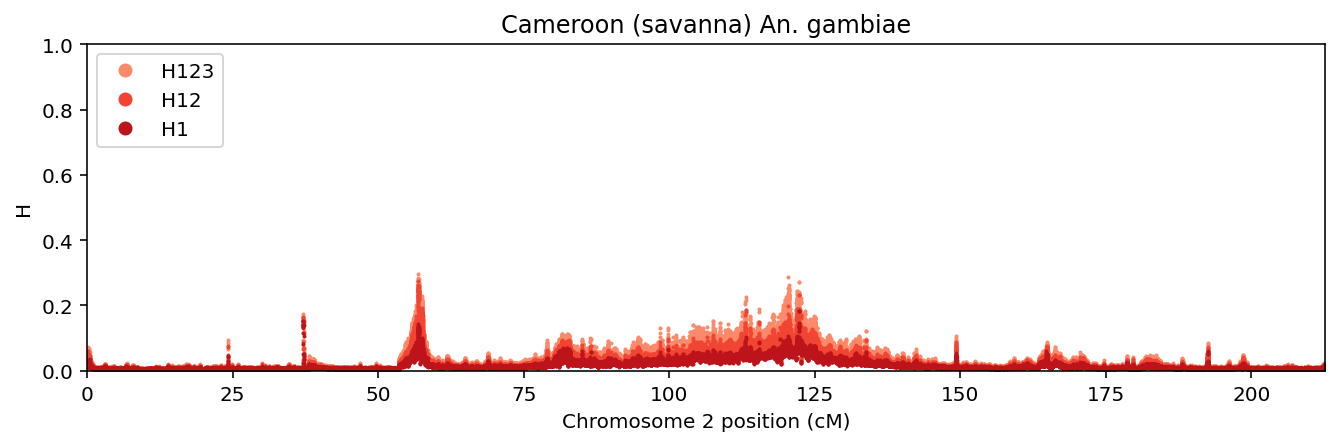

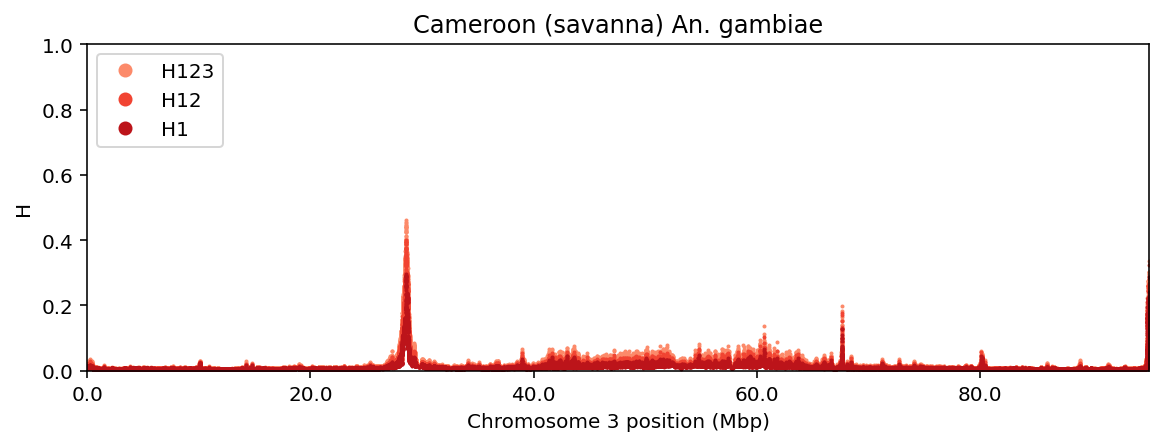

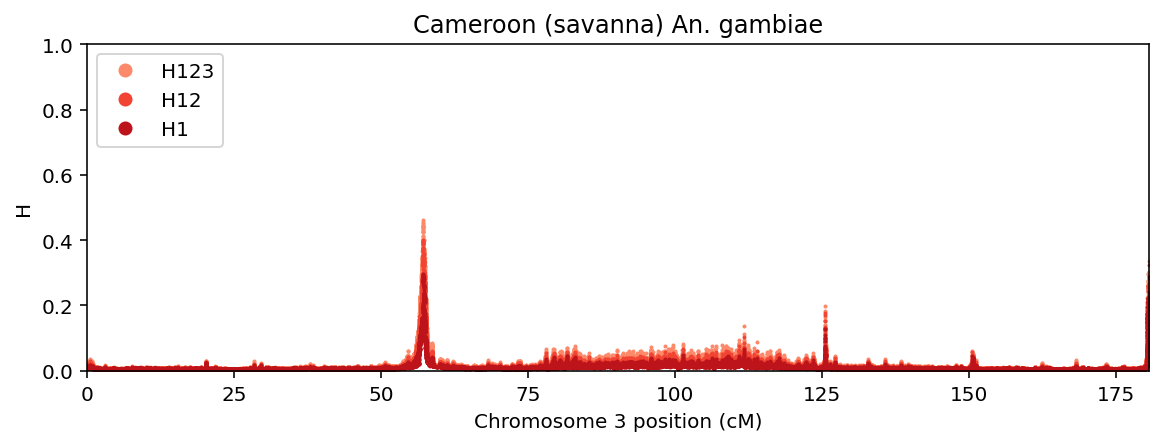

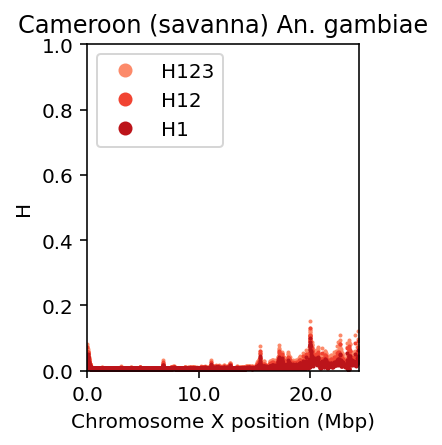

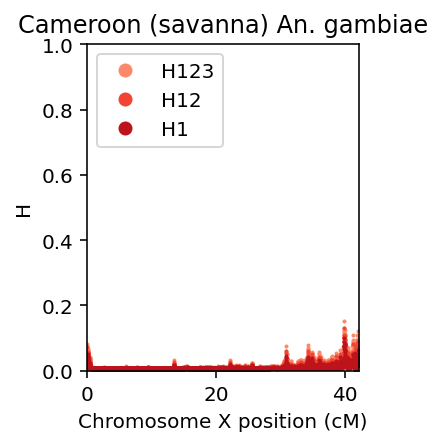

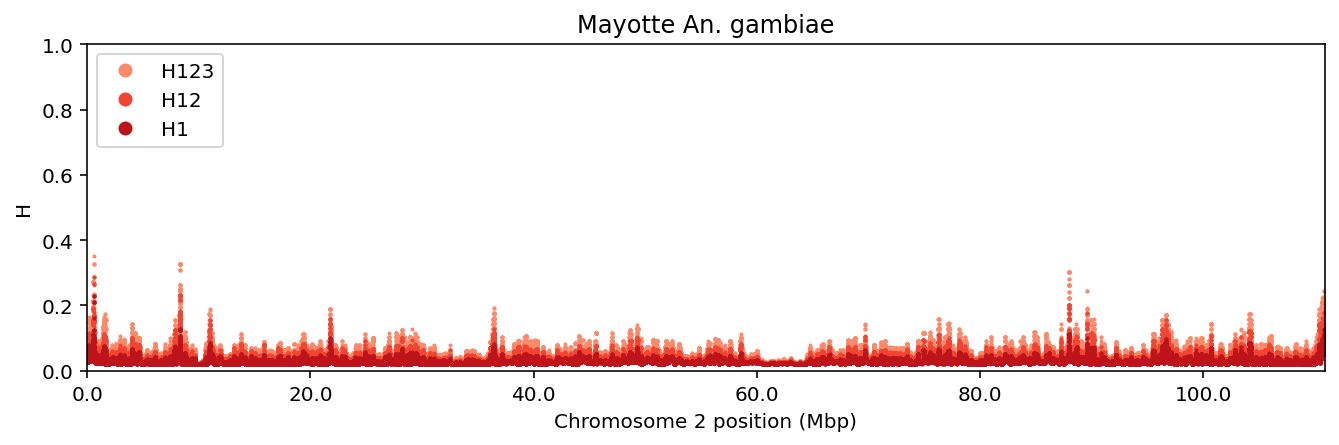

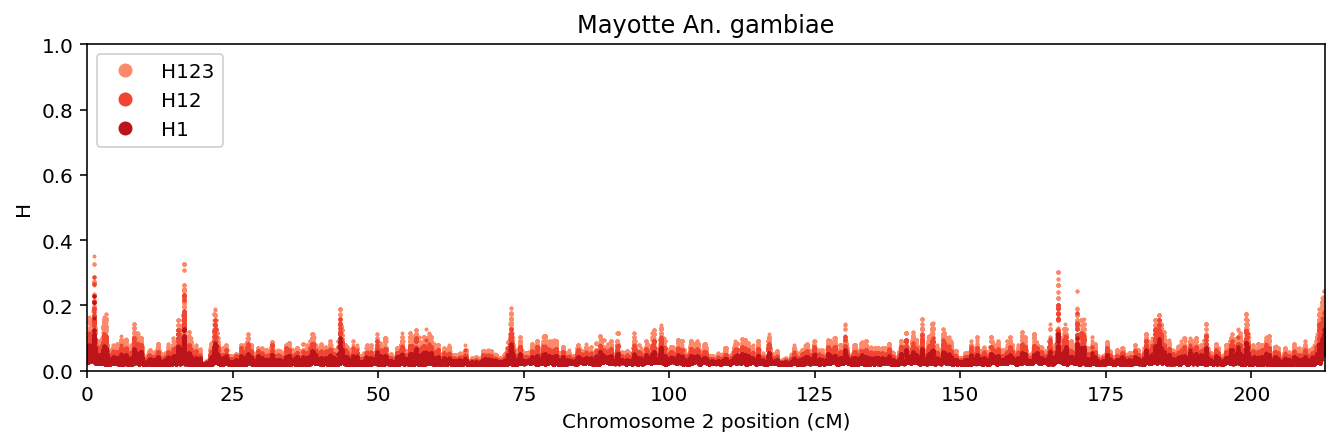

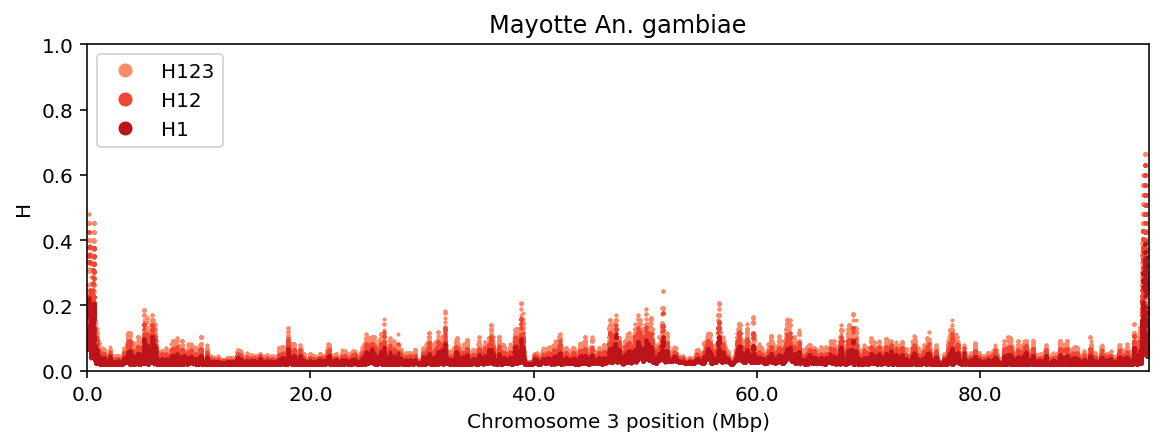

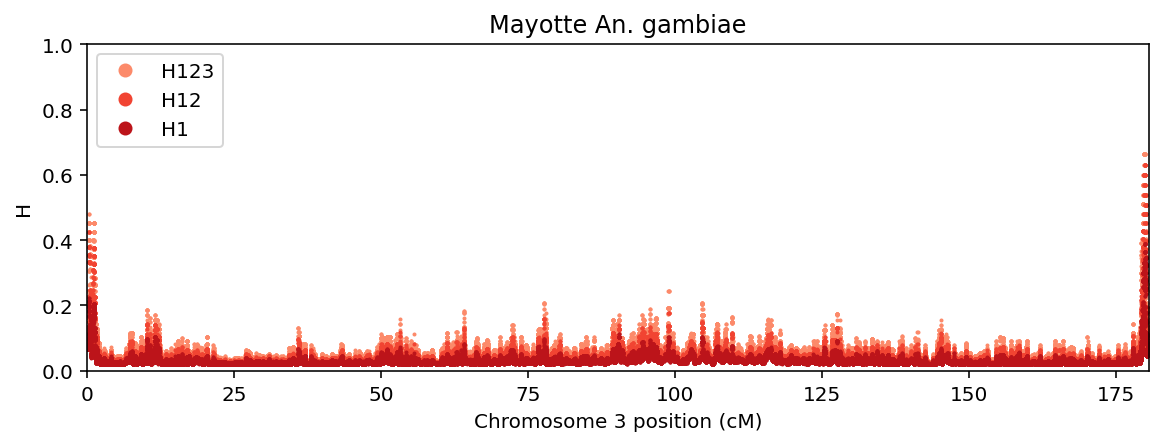

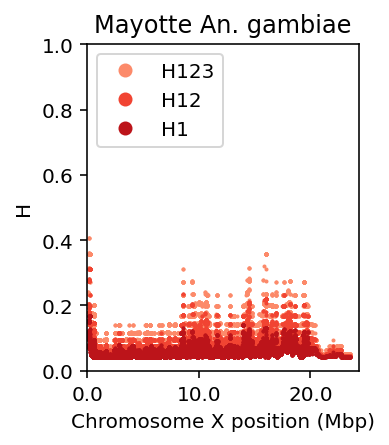

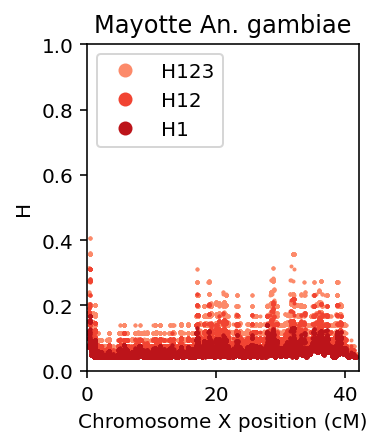

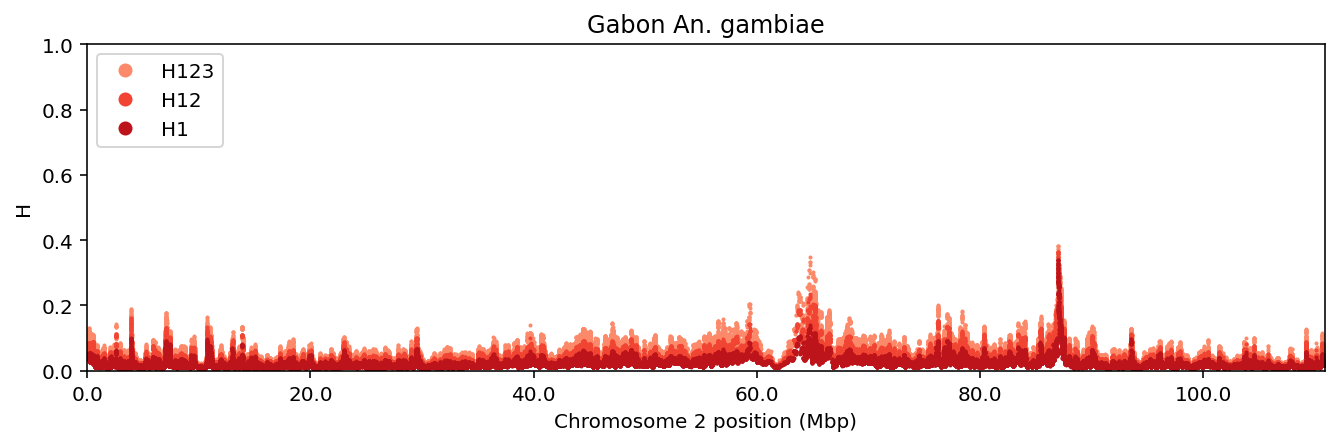

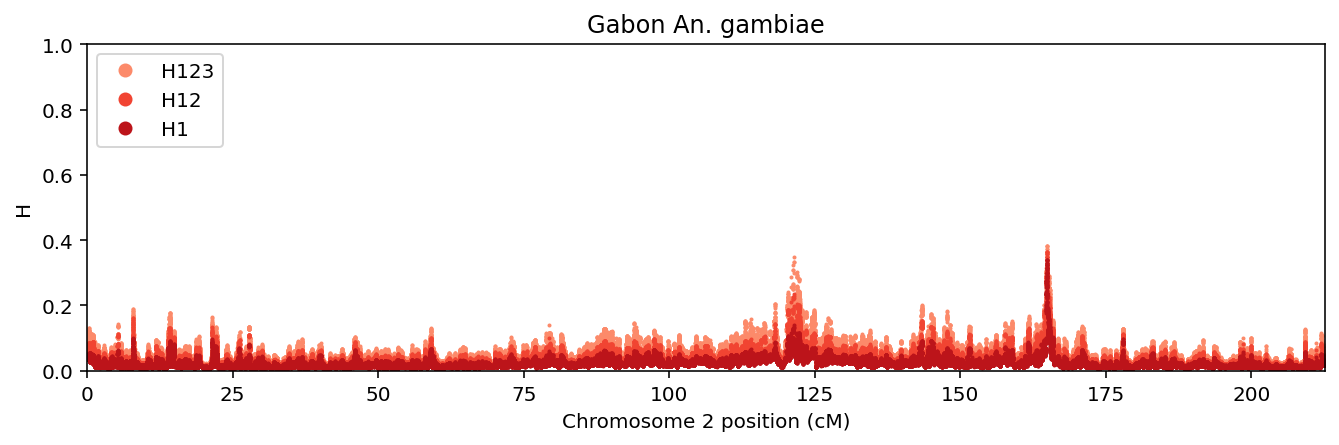

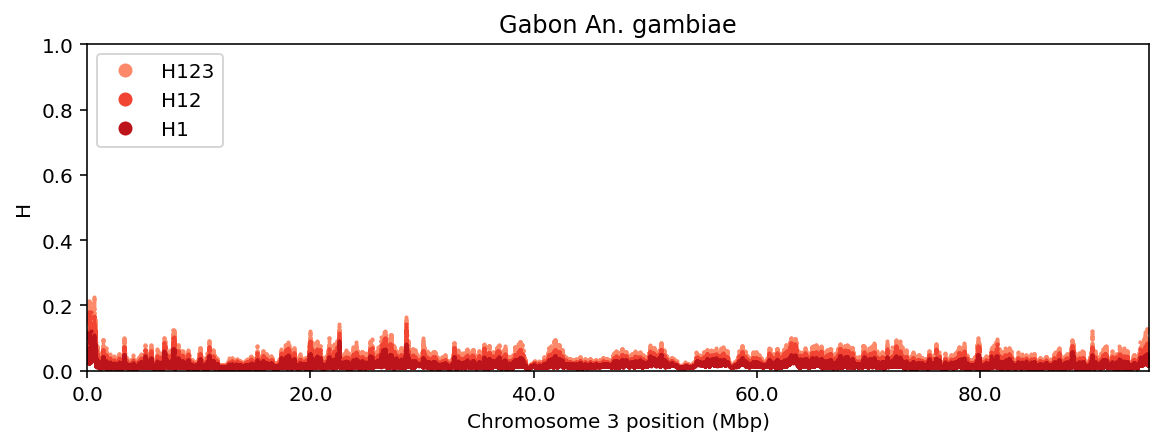

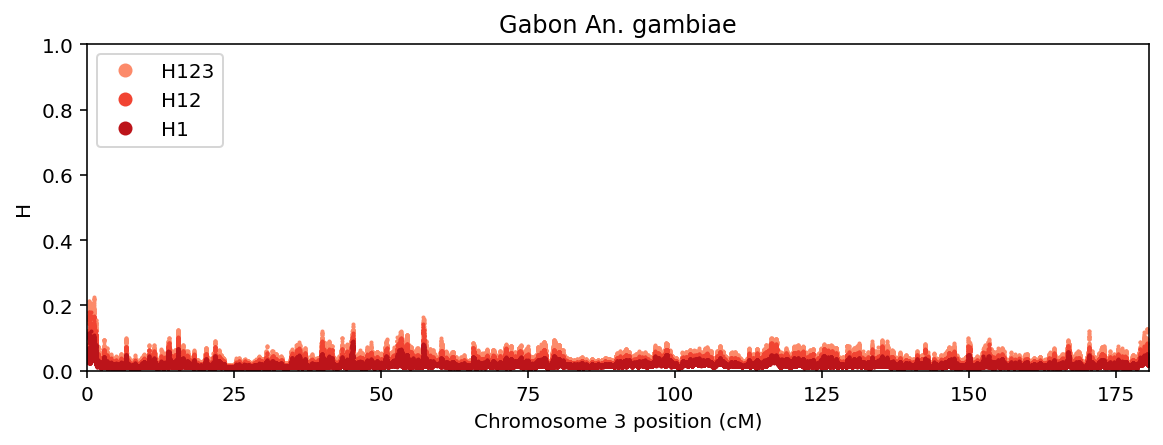

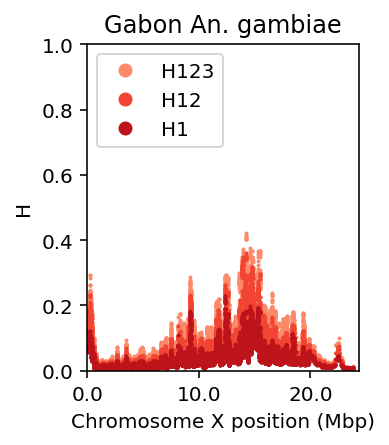

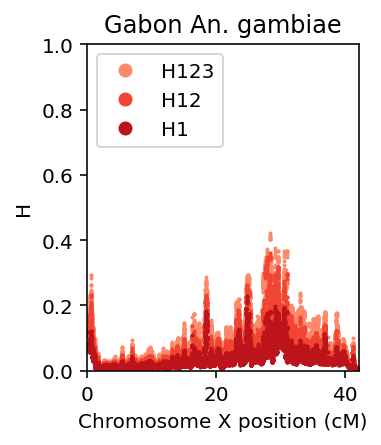

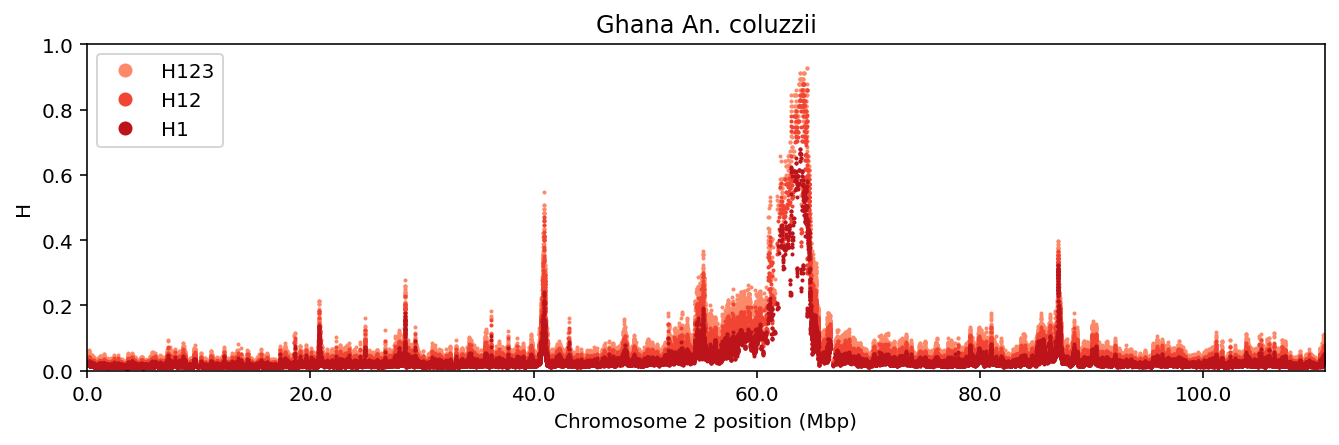

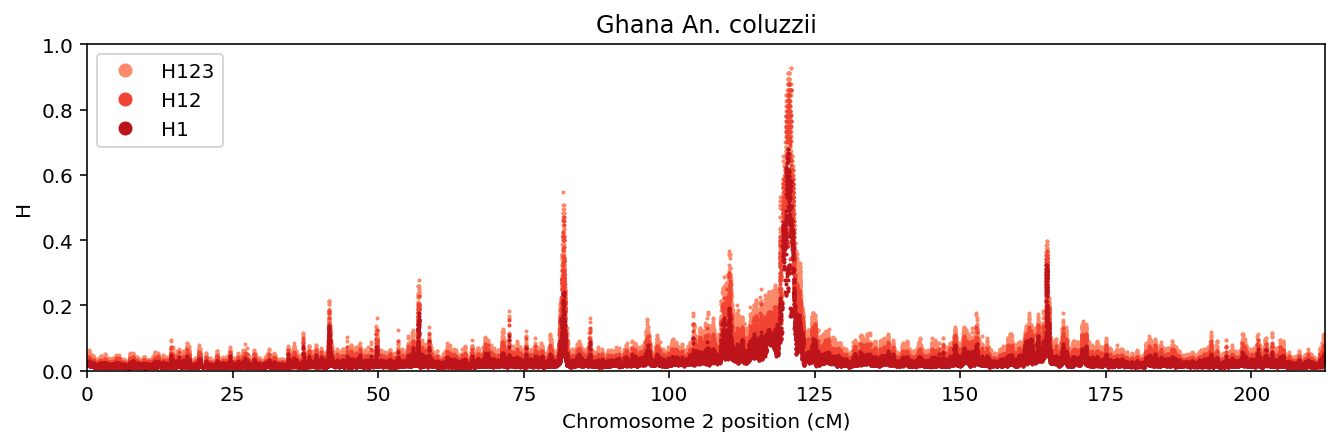

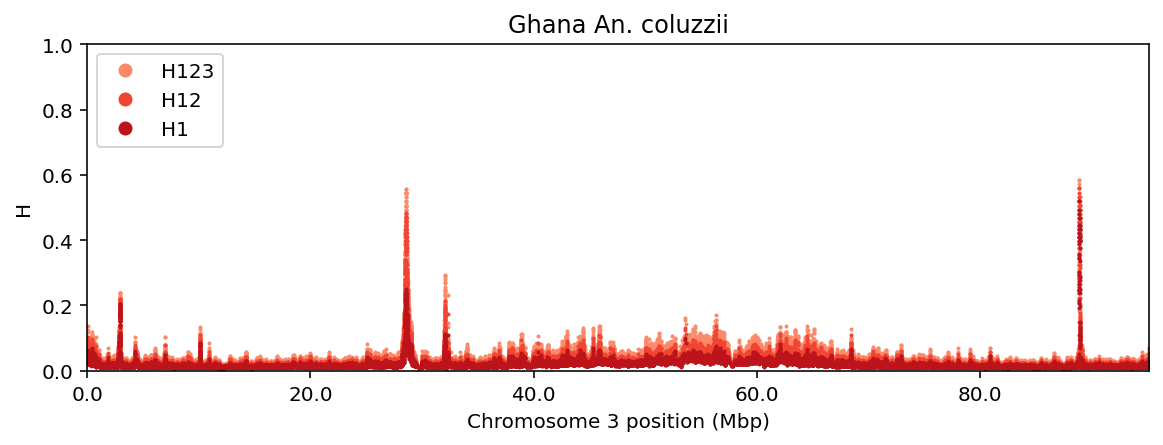

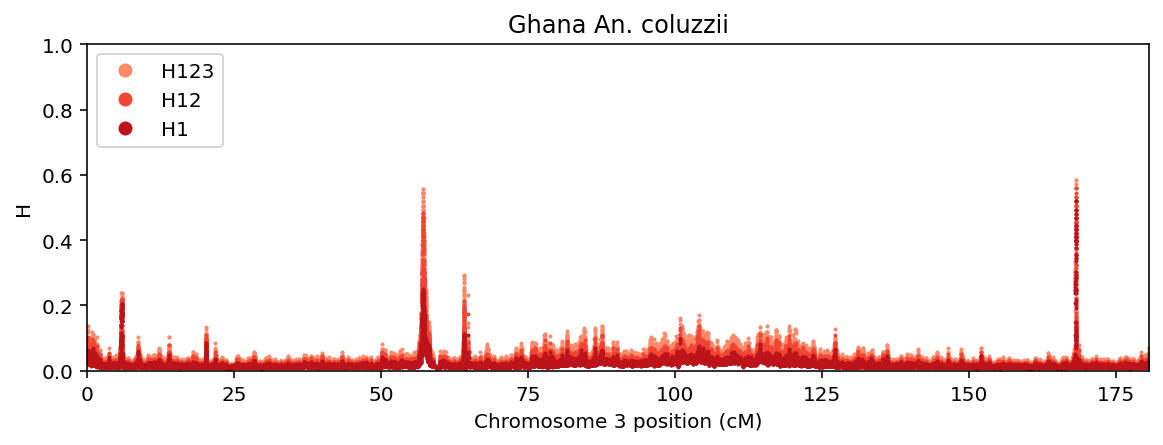

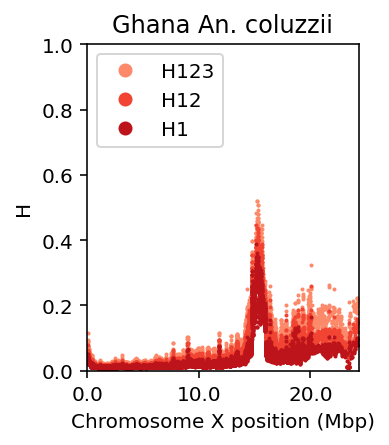

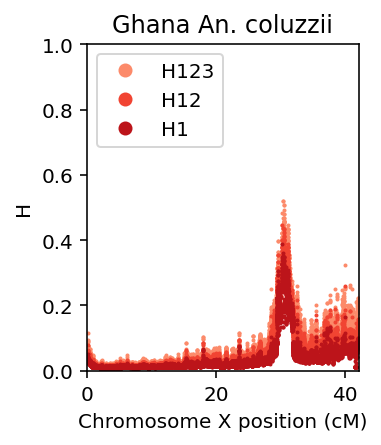

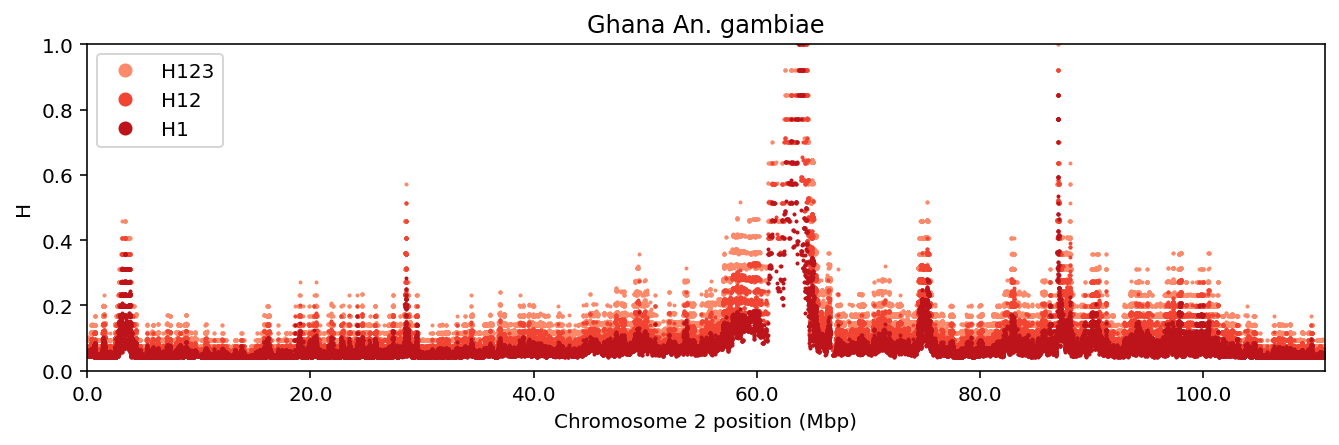

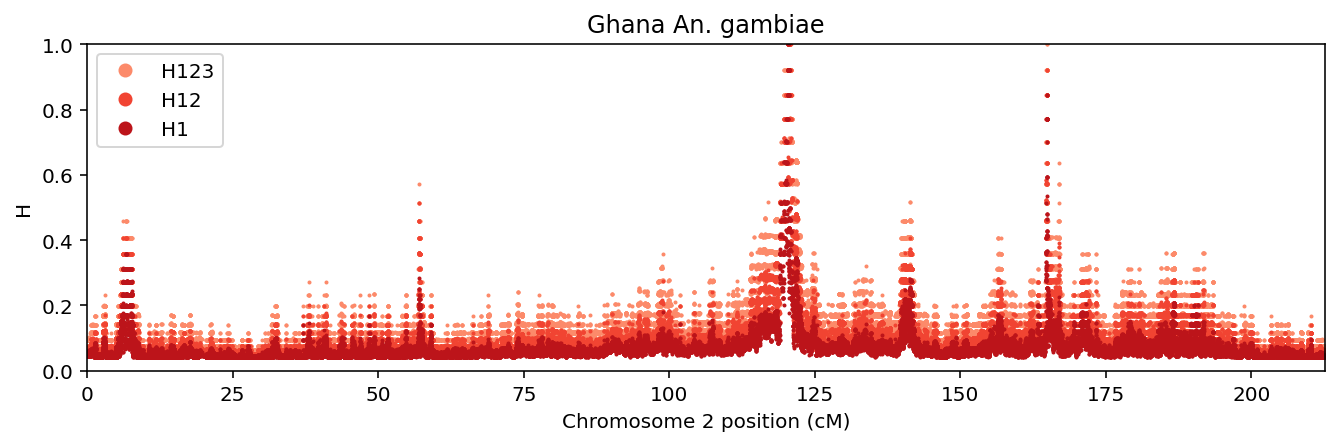

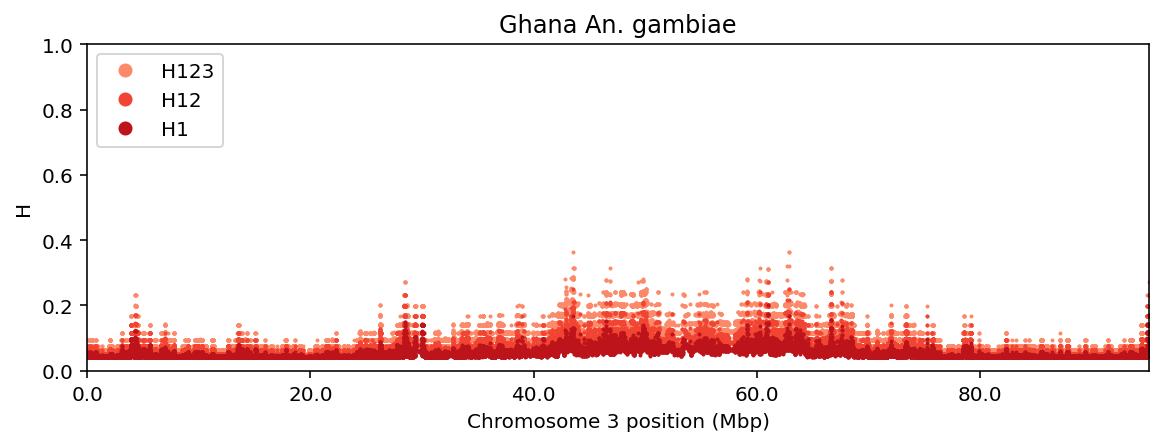

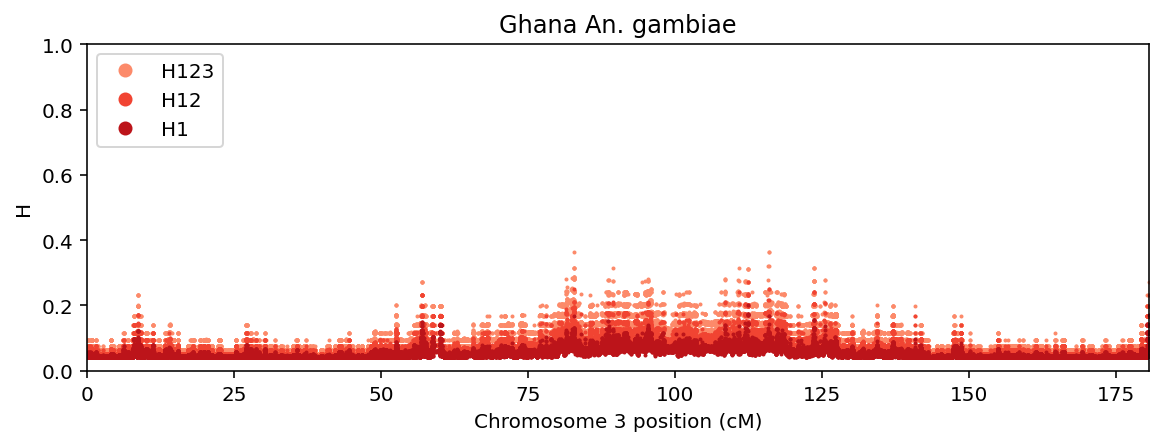

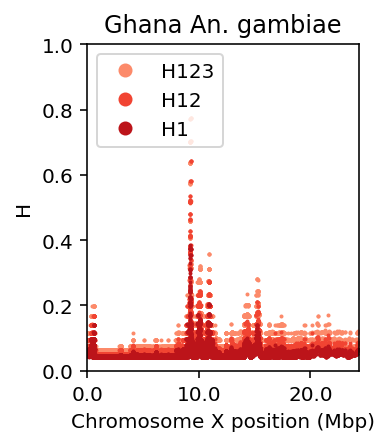

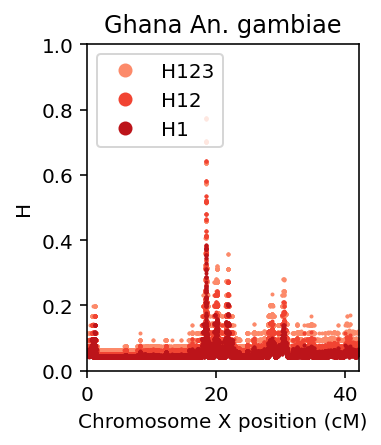

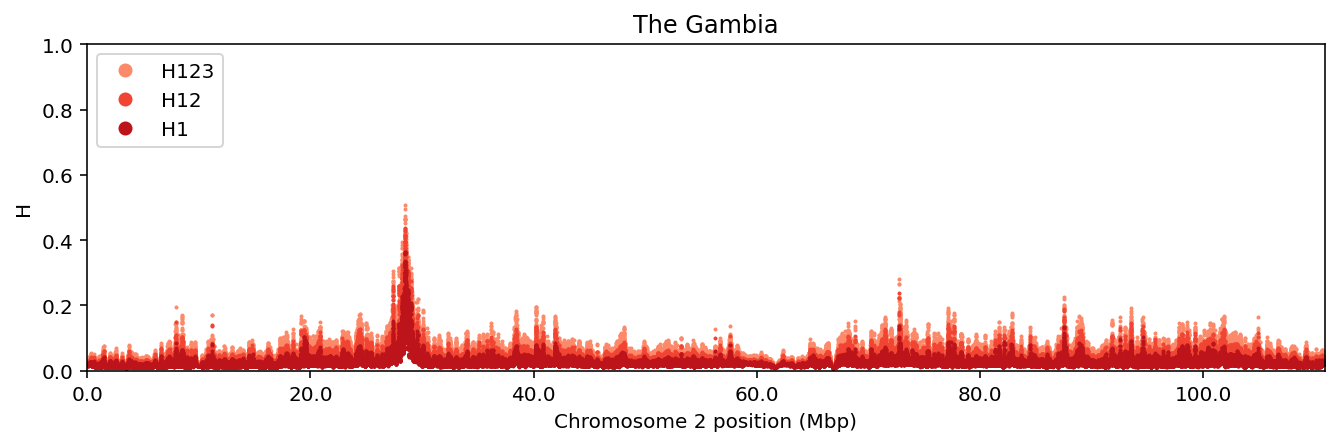

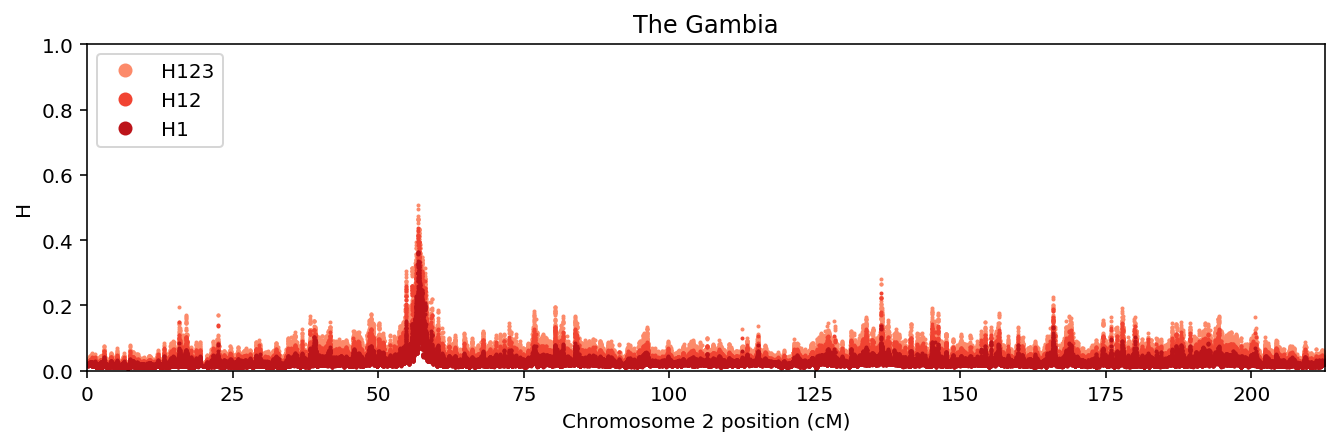

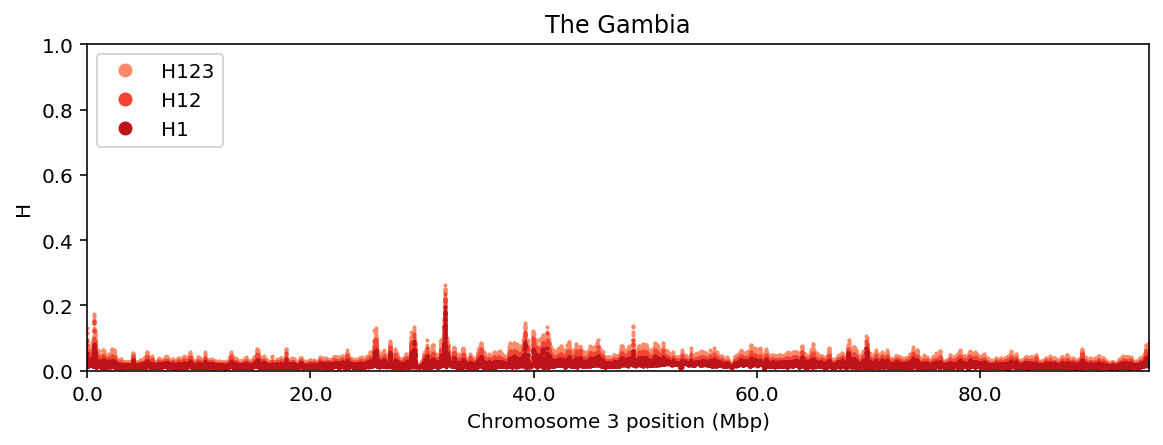

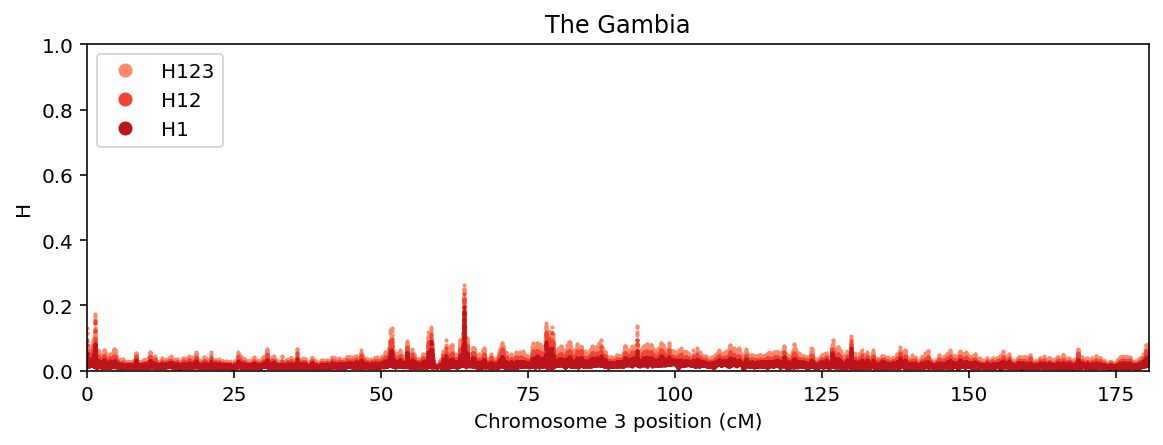

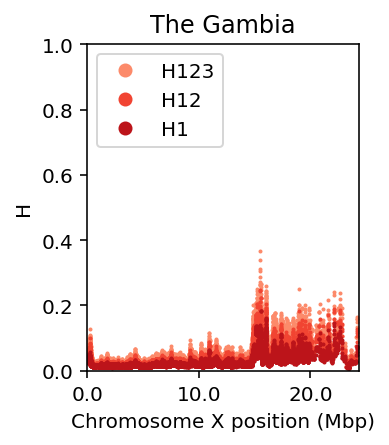

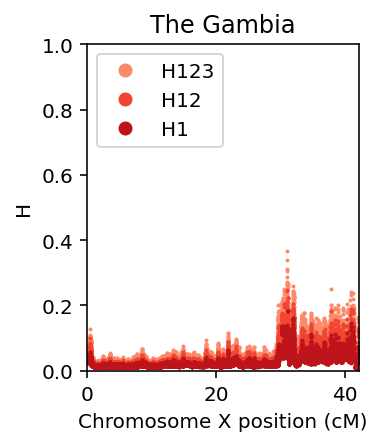

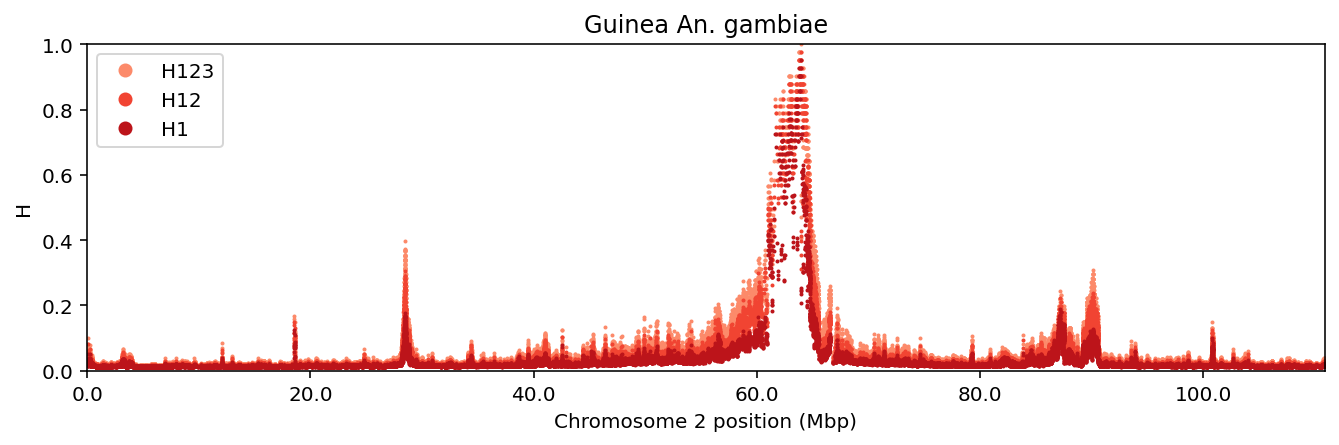

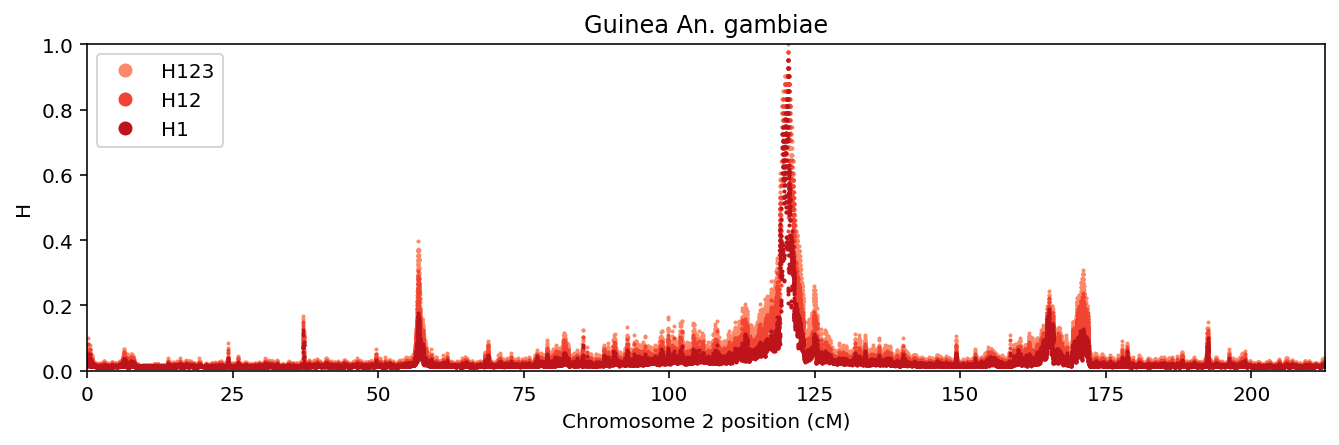

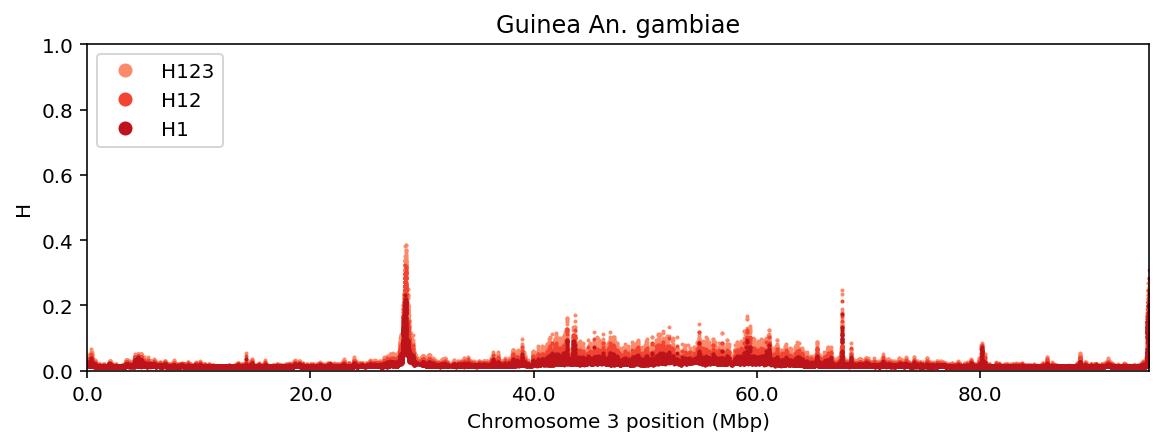

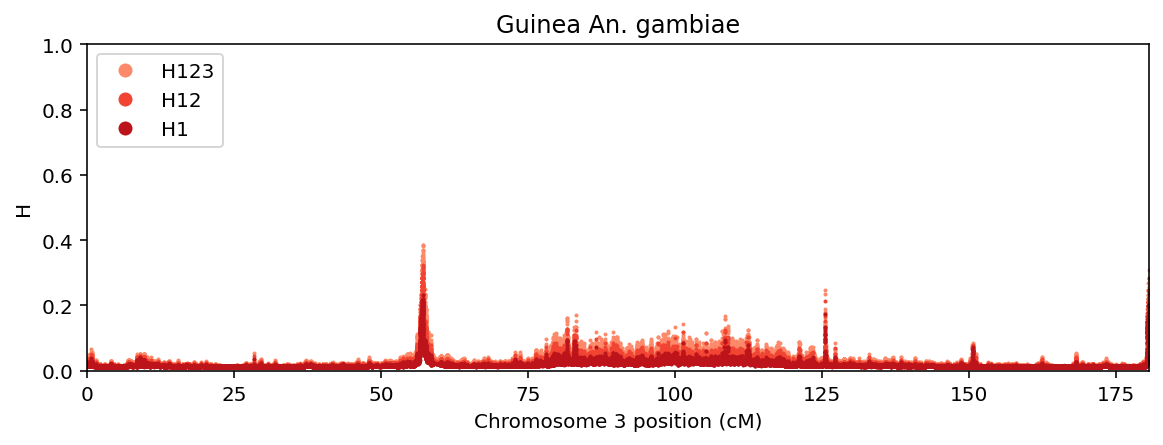

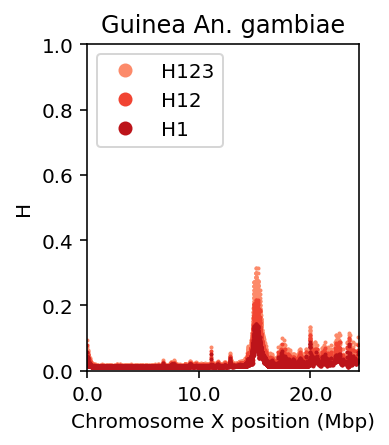

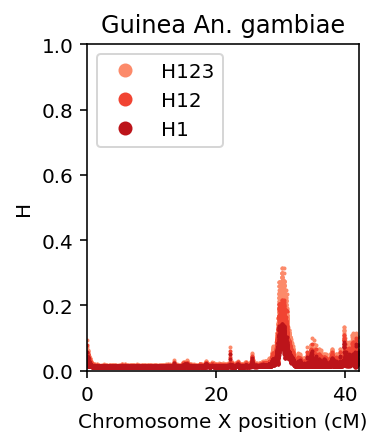

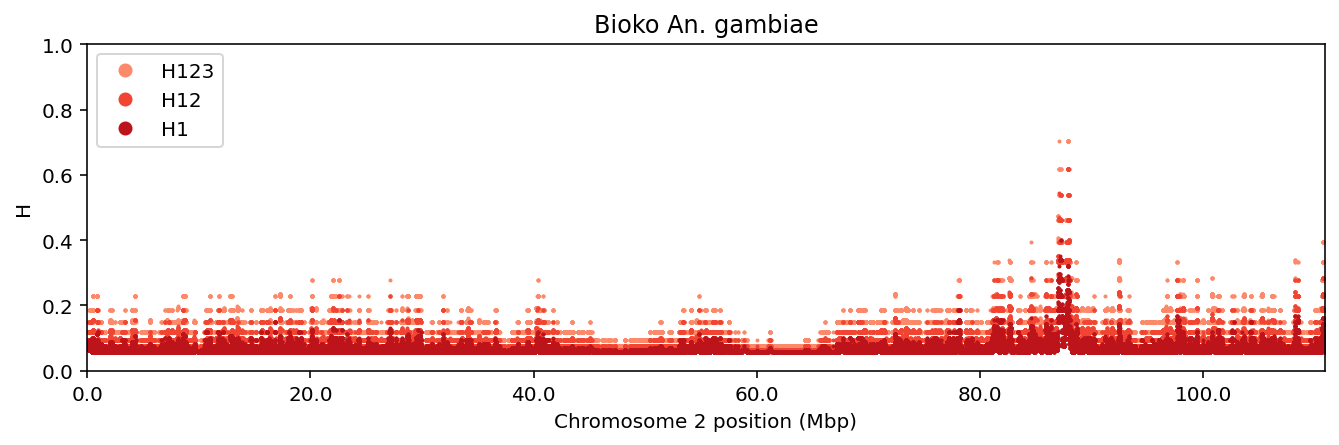

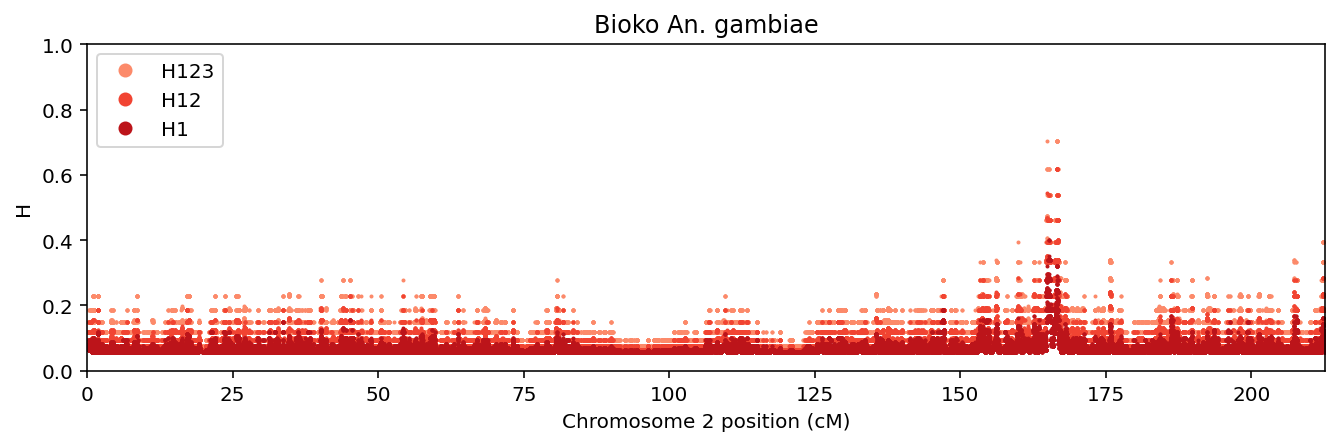

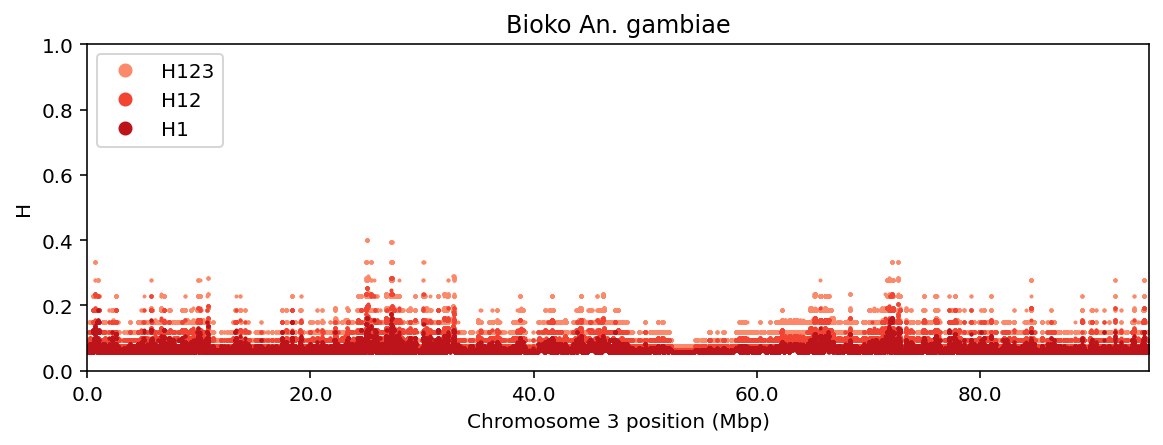

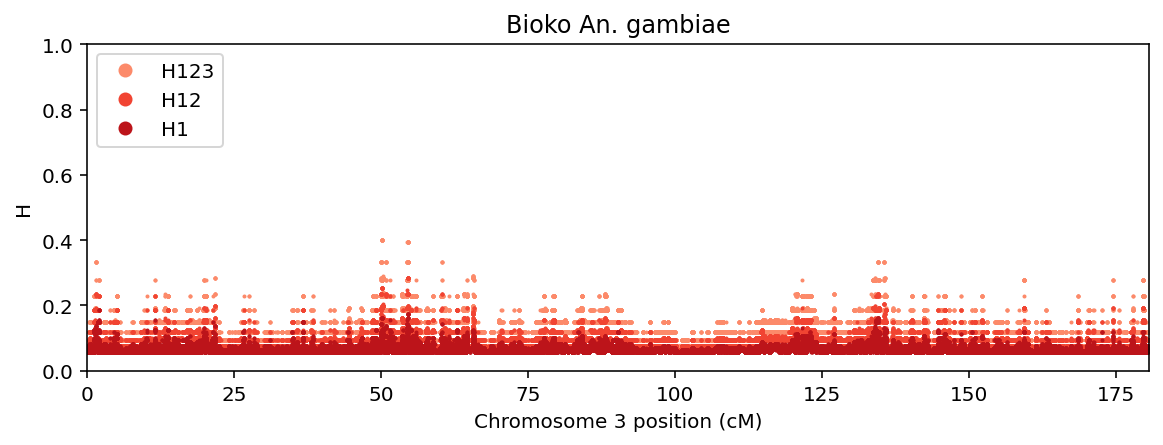

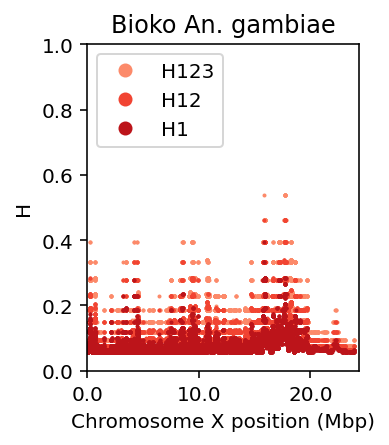

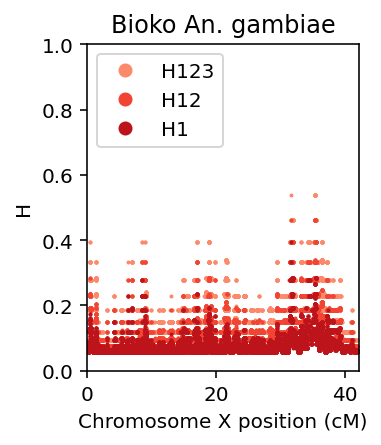

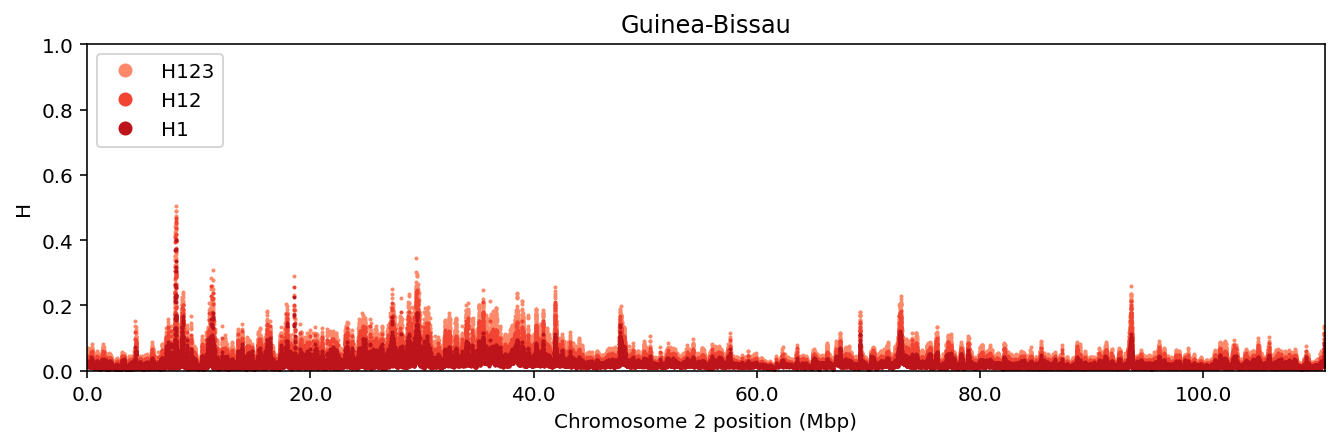

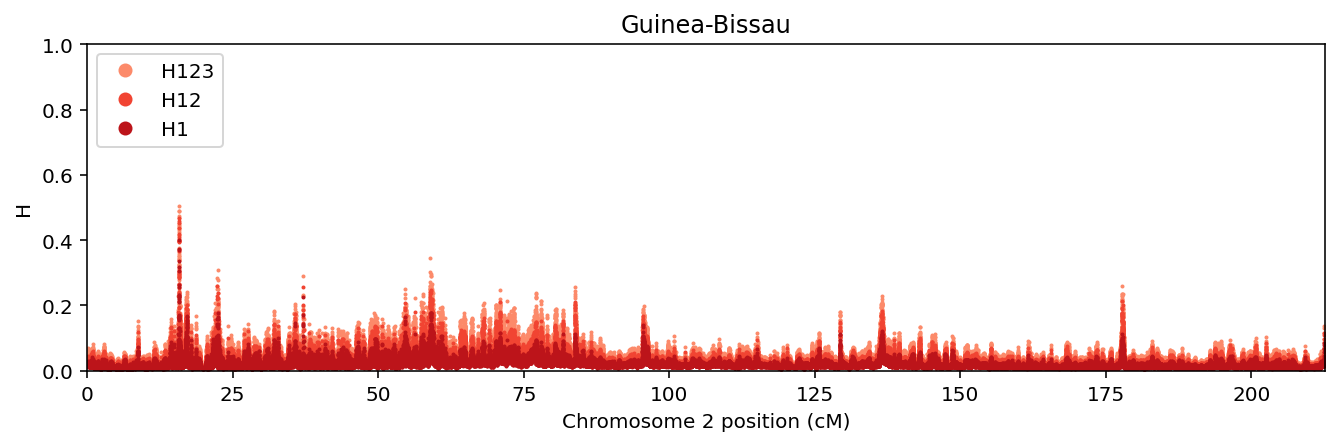

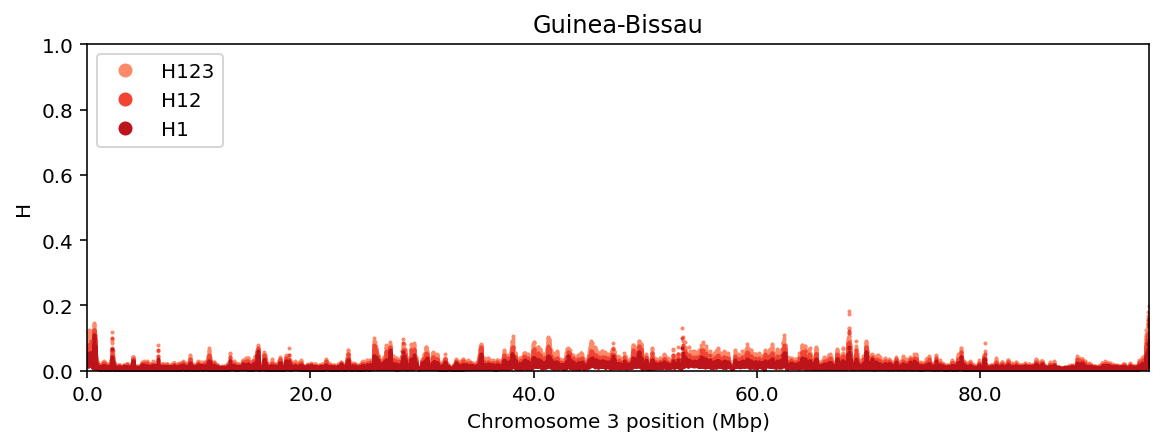

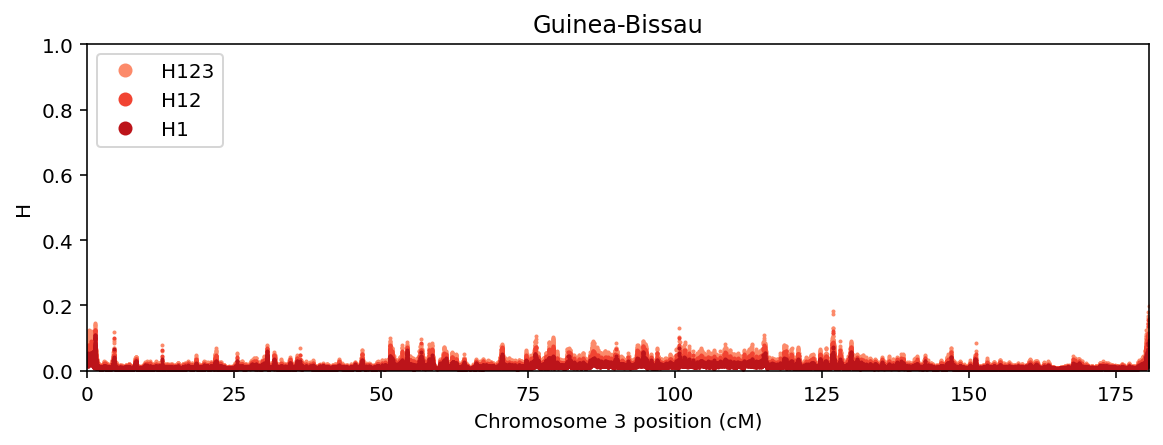

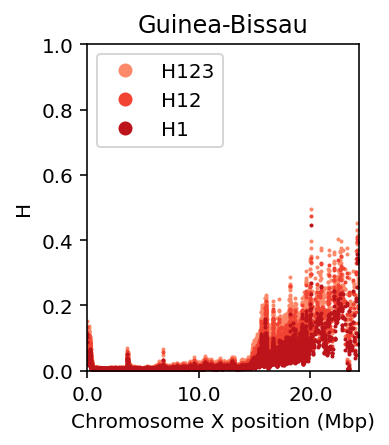

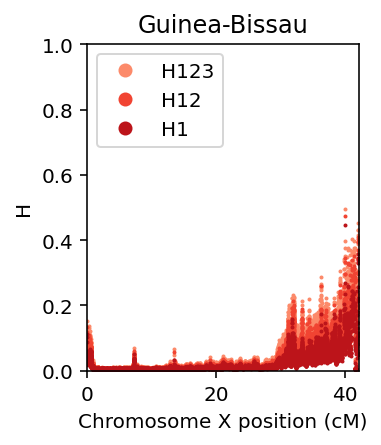

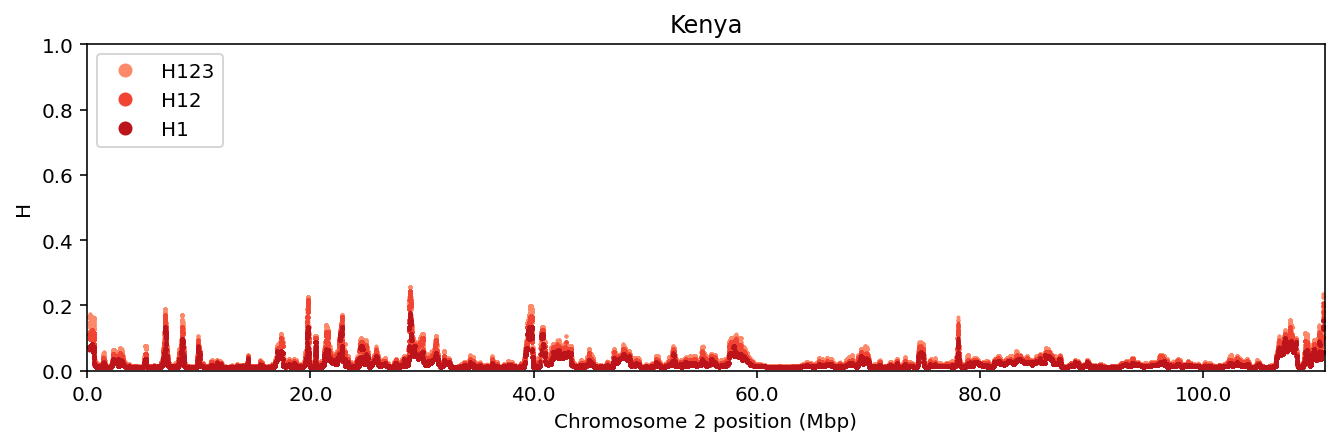

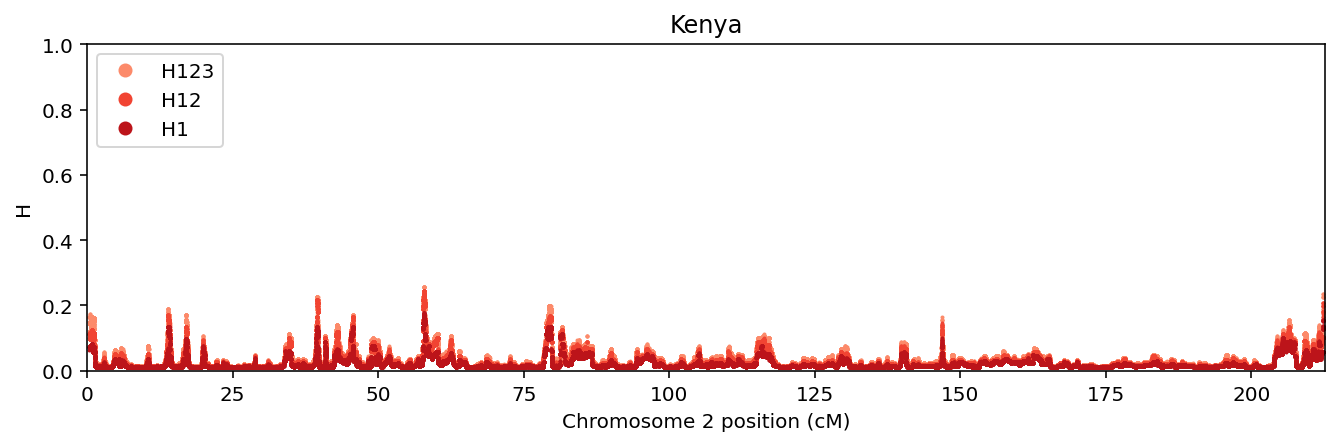

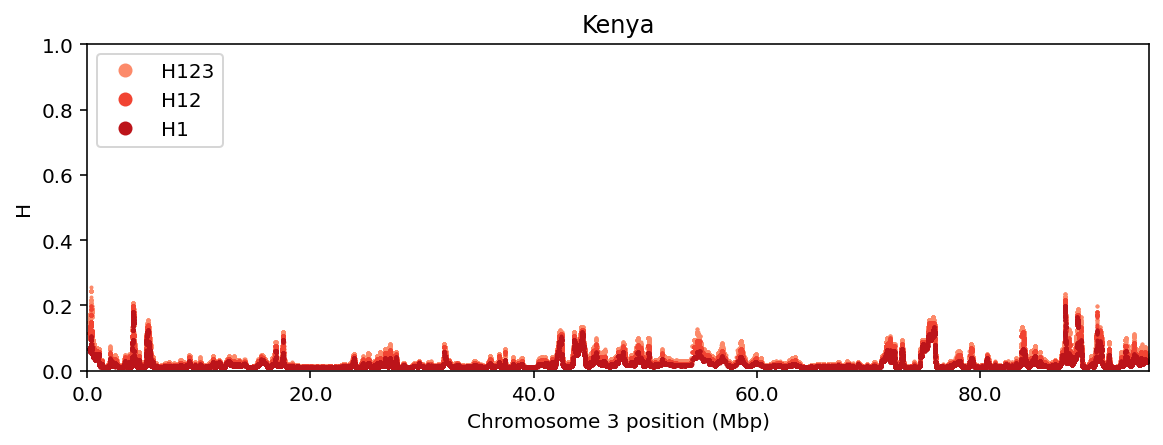

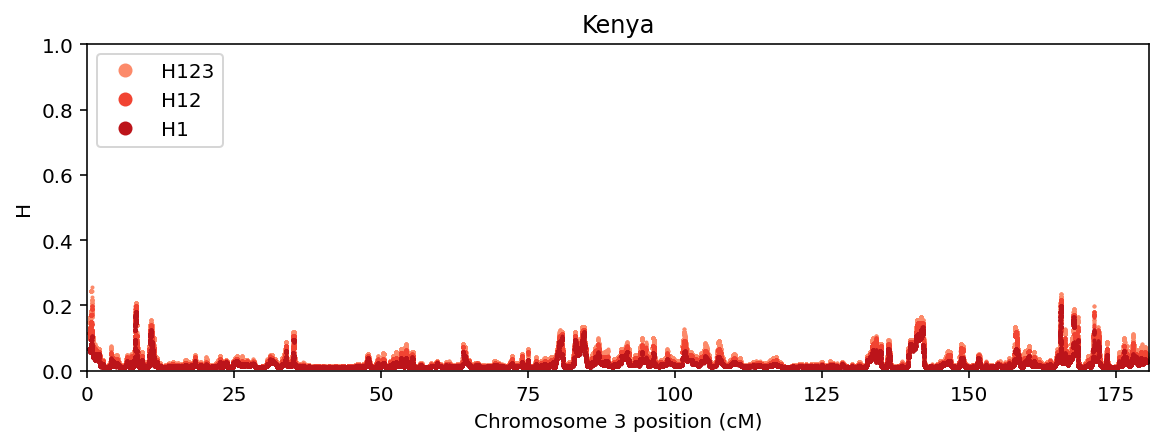

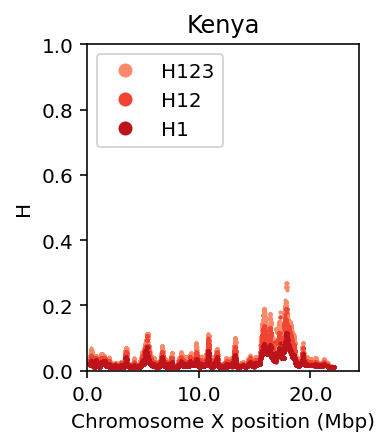

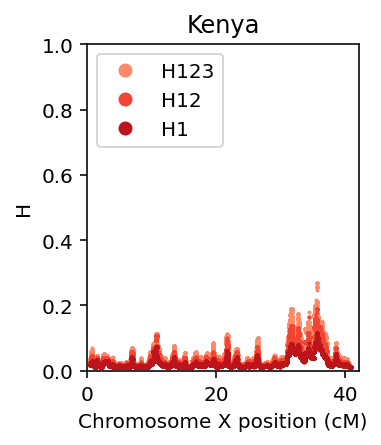

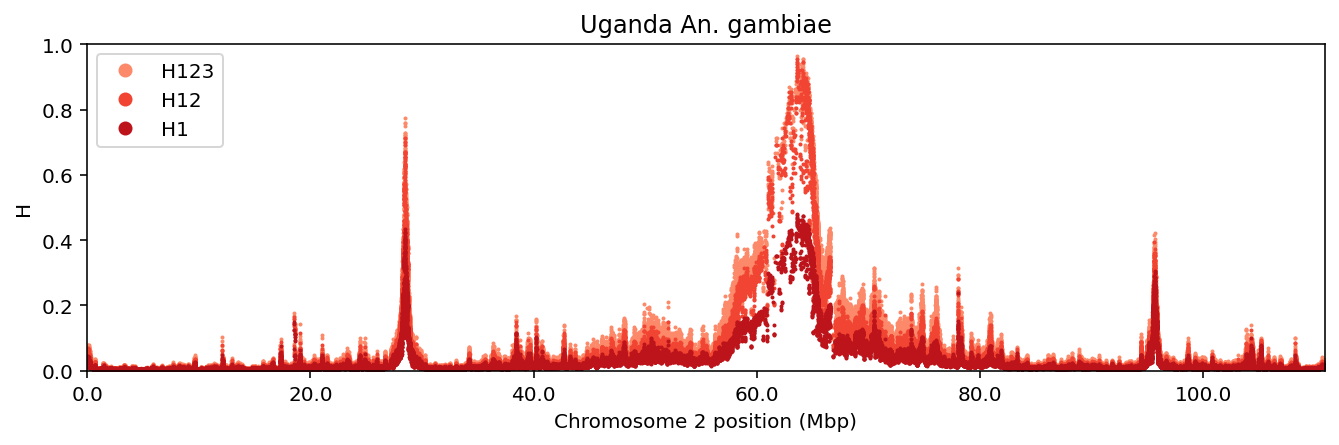

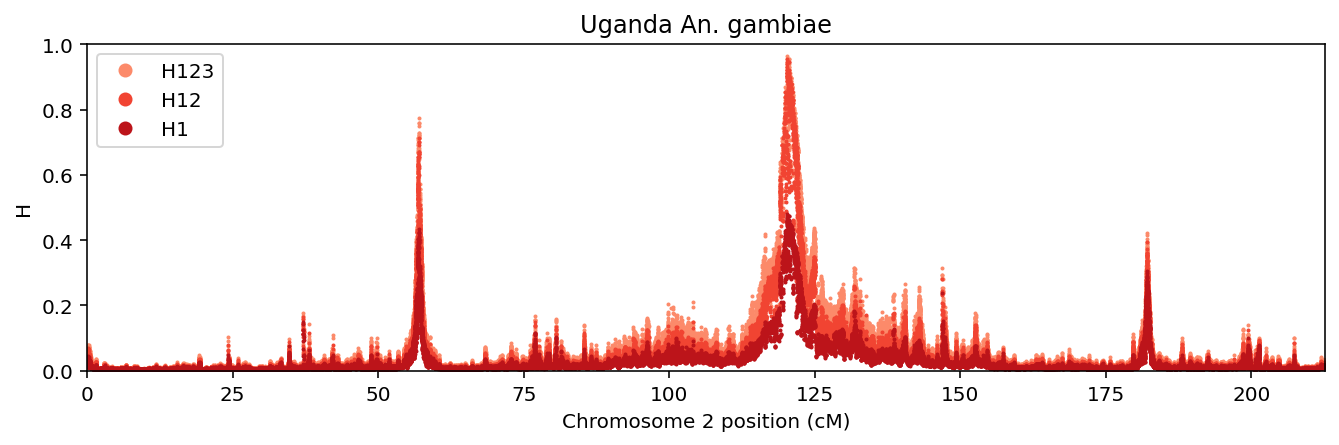

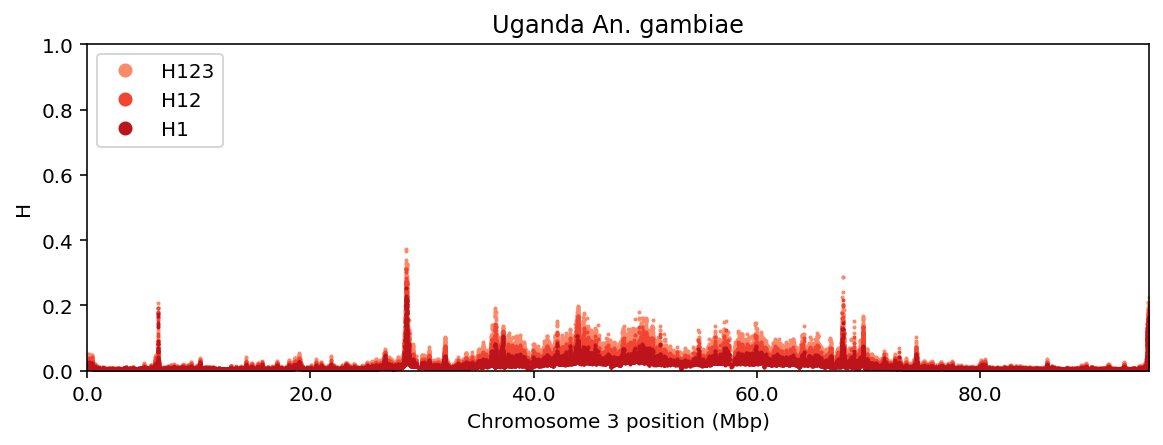

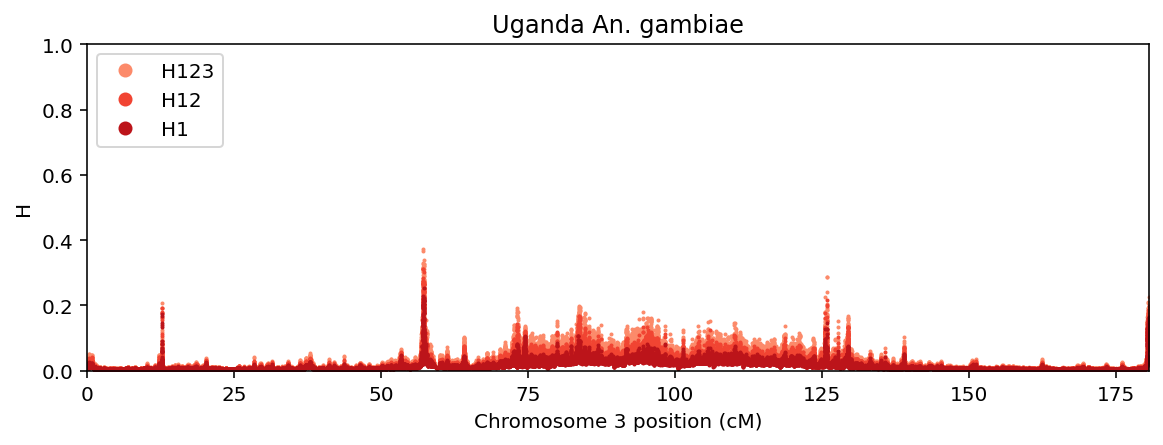

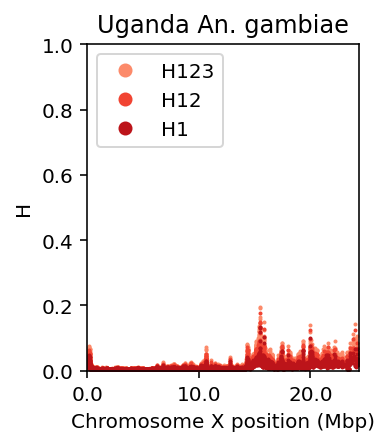

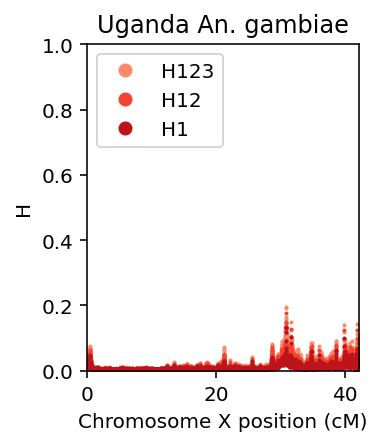

In [7]:
for pop in pops:
    for chromosome in '2', '3', 'X':
        run_h12(pop, chromosome)

In [8]:
print(h12_root.tree())

/
 ├── ao_col
 │   └── 6000
 │       └── 200
 │           ├── 2
 │           │   ├── gwindows (104742, 2) float64
 │           │   ├── h1 (104742,) float64
 │           │   ├── h12 (104742,) float64
 │           │   ├── h123 (104742,) float64
 │           │   ├── h2_h1 (104742,) float64
 │           │   └── windows (104742, 2) int32
 │           ├── 3
 │           │   ├── gwindows (93222, 2) float64
 │           │   ├── h1 (93222,) float64
 │           │   ├── h12 (93222,) float64
 │           │   ├── h123 (93222,) float64
 │           │   ├── h2_h1 (93222,) float64
 │           │   └── windows (93222, 2) int32
 │           └── X
 │               ├── gwindows (22332, 2) float64
 │               ├── h1 (22332,) float64
 │               ├── h12 (22332,) float64
 │               ├── h123 (22332,) float64
 │               ├── h2_h1 (22332,) float64
 │               └── windows (22332, 2) int32
 ├── bf_col
 │   └── 1000
 │       └── 200
 │           ├── 2
 │           │   ├── gwindows (1047

In [9]:
zarr.consolidate_metadata(h12_root.store)

<zarr.hierarchy.Group '/'>